## Imports

In [1]:
import math
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from my_ecog_utils import read_with_annotations, get_multitaper_power_bands, get_multitaper_power_bands_narrow

## Power Calcs

In [2]:
pts_w_any_stim = [100, 103, 105, 106, 109, 110, 111, 112, 113, 115]
freqs = ['Delta', 'Theta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']

results_before_after = pd.DataFrame(columns=['ID', 'Stim', 'Trial', 'Channel', *freqs])
results_before_after.loc[:,'Stim'] = results_before_after['Stim'].astype('bool')

for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    
    # if you ever need to debug, look at the drop logs
    print(epochs.drop_log)
    trial_num = 0
    epoch_num = 0
    shock_num = 1
    for i in range(len(epochs.drop_log)):
        epoch = epochs[epoch_num]
        shock_num += 1
        if epochs.drop_log[i] == ('BAD_',):
            continue
        is_post_stim = 'post_shock' in epoch.event_id
        if not is_post_stim:
            trial_num += 1
            shock_num = 0
        for chan in epochs.ch_names:
            powers = get_multitaper_power_bands(epoch, picks=chan, split_gamma=True)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': is_post_stim, 'Trial': trial_num, 'Channel': chan, 'Stim_Num': shock_num, **powers}, ignore_index=True)
        epoch_num += 1

results_before_after.to_csv('each_stim_before_after.csv', index=False)
results_before_after

Opening raw data file data/100/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 51647 =      0.000 ...   206.588 secs
Ready.
Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 251 original time points ...
0 bad epochs dropped
((), (), (), (), (), (), (), (), (), (), (), (), (), (), ())
Opening raw data file data/103/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 58391 =      0.000 ...   233.564 secs
Ready.
Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 17 events and 251 original time points ...
2 bad epochs dropped
((), (), (), (), (), (), ('BAD_',), (), (), (), (), (), ('BAD_',), (), (), (), ())
Opening raw data file data/105

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


ID   Stim Trial        Channel         Delta         Theta  \
0    100  False     1  LHip1 - LHip2  7.675365e-08  7.964023e-08   
1    100  False     1  LHip3 - LHip4  7.598541e-08  5.434720e-08   
2    100  False     1  LatT1 - LatT2  1.777270e-09  1.945628e-09   
3    100  False     1  LatT3 - LatT4  1.063216e-08  1.579312e-08   
4    100   True     1  LHip1 - LHip2  1.142265e-07  7.160084e-08   
..   ...    ...   ...            ...           ...           ...   
559  115   True     3  RHip3 - RHip4  9.363271e-08  3.897587e-08   
560  115   True     3  LHip1 - LHip2  7.929626e-08  3.845487e-08   
561  115   True     3  LHip3 - LHip4  2.255357e-08  1.186926e-08   
562  115   True     3  RHip1 - RHip2  9.710153e-08  5.704938e-08   
563  115   True     3  RHip3 - RHip4  9.522910e-08  4.835513e-08   

         GammaLow      GammaMed     GammaHigh    GammaXHigh         Alpha  \
0    9.995214e-10  3.829484e-10  1.339650e-10  3.154425e-11  3.897323e-08   
1    7.575780e-10  1.174397e-10  5.143055e-11  2.134317e-11  7.956121e-09   
2    4.596234e-11  1.801090e-11  1.138041e-11  7.311408e-12  7.835720e-10   
3    2.038631e-10  5.548163e-11  2.411441e-11  2.013046e-11  8.961324e-09   
4    9.921538e-10  4.940207e-10  9.829770e-11  4.085140e-11  2.537739e-08   
..            ...           ...           ...           ...           ...   
559  3.496571e-10  6.268967e-11  1.797880e-11  8.771414e-12  1.177354e-08   
560  1.617707e-10  3.981762e-11  3.563167e-11  1.107687e-11  8.027191e-09   
561  9.900935e-11  3.259036e-11  1.284539e-11  7.066029e-12  4.359343e-09   
562  1.300694e-10  4.873521e-11  8.070271e-12  6.551630e-12  2.026179e-08   
563  1.603349e-10  3.522431e-11  1.273296e-11  7.681334e-12  8.531587e-09   

             Beta  Stim_Num  
0    1.350544e-08       0.0  
1    3.615258e-09       0.0  
2    2.447682e-10       0.0  
3    1.446633e-09       0.0  
4    1.168896e-08       1.0  
..            ...       ...  
559  1.675841e-09       3.0  
560  1.502477e-09       4.0  
561  1.080160e-09       4.0  
562  1.891782e-09       4.0  
563  1.652239e-09       4.0  

[564 rows x 13 columns]

In [3]:
results_before_after['Stim_Num'] = results_before_after['Stim_Num'].astype(int)

In [4]:
# ensures that pre-shock is always set to Stim Number 0
assert ((results_before_after['Stim'] != False) & (results_before_after['Stim_Num'] == 0)).sum() == 0

In [5]:
# results_before_after = pd.read_csv('each_stim_before_after.csv')
# results_before_after

In [6]:
baselines = results_before_after[results_before_after['Stim'] == False]
stims = results_before_after[results_before_after['Stim'] == True]

In [7]:
rearranged = stims.merge(baselines, on=['ID', 'Trial', 'Channel'], suffixes=['_post', '_pre'])
rearranged = rearranged.drop(['Stim_post', 'Stim_pre'], axis='columns')
rearranged

ID Trial        Channel    Delta_post    Theta_post  GammaLow_post  \
0    100     1  LHip1 - LHip2  1.142265e-07  7.160084e-08   9.921538e-10   
1    100     1  LHip1 - LHip2  5.835607e-08  3.228236e-08   1.174717e-09   
2    100     1  LHip1 - LHip2  5.101219e-08  3.539530e-08   9.132759e-10   
3    100     1  LHip1 - LHip2  8.637263e-08  8.009507e-08   5.182578e-10   
4    100     1  LHip3 - LHip4  3.783933e-07  7.525865e-08   7.594196e-10   
..   ...   ...            ...           ...           ...            ...   
443  115     3  RHip1 - RHip2  9.710153e-08  5.704938e-08   1.300694e-10   
444  115     3  RHip3 - RHip4  1.015435e-07  2.902098e-08   1.991359e-10   
445  115     3  RHip3 - RHip4  3.798745e-08  1.329782e-08   1.610107e-10   
446  115     3  RHip3 - RHip4  9.363271e-08  3.897587e-08   3.496571e-10   
447  115     3  RHip3 - RHip4  9.522910e-08  4.835513e-08   1.603349e-10   

     GammaMed_post  GammaHigh_post  GammaXHigh_post    Alpha_post  ...  \
0     4.940207e-10    9.829770e-11     4.085140e-11  2.537739e-08  ...   
1     3.131012e-10    1.467104e-10     3.619705e-11  2.086106e-08  ...   
2     2.502662e-10    1.111956e-10     2.223456e-11  3.576351e-08  ...   
3     2.529154e-10    8.058721e-11     4.343609e-11  4.598535e-08  ...   
4     1.359819e-10    8.057761e-11     2.862910e-11  5.945015e-09  ...   
..             ...             ...              ...           ...  ...   
443   4.873521e-11    8.070271e-12     6.551630e-12  2.026179e-08  ...   
444   4.883452e-11    1.613729e-11     1.043151e-11  3.395587e-09  ...   
445   3.660184e-11    1.480987e-11     7.810272e-12  2.843842e-09  ...   
446   6.268967e-11    1.797880e-11     8.771414e-12  1.177354e-08  ...   
447   3.522431e-11    1.273296e-11     7.681334e-12  8.531587e-09  ...   

     Stim_Num_post     Delta_pre     Theta_pre  GammaLow_pre  GammaMed_pre  \
0                1  7.675365e-08  7.964023e-08  9.995214e-10  3.829484e-10   
1                2  7.675365e-08  7.964023e-08  9.995214e-10  3.829484e-10   
2                3  7.675365e-08  7.964023e-08  9.995214e-10  3.829484e-10   
3                4  7.675365e-08  7.964023e-08  9.995214e-10  3.829484e-10   
4                1  7.598541e-08  5.434720e-08  7.575780e-10  1.174397e-10   
..             ...           ...           ...           ...           ...   
443              4  6.393486e-08  1.257354e-08  1.478612e-10  3.166754e-11   
444              1  5.951198e-08  1.537675e-08  3.234453e-10  3.728408e-11   
445              2  5.951198e-08  1.537675e-08  3.234453e-10  3.728408e-11   
446              3  5.951198e-08  1.537675e-08  3.234453e-10  3.728408e-11   
447              4  5.951198e-08  1.537675e-08  3.234453e-10  3.728408e-11   

     GammaHigh_pre  GammaXHigh_pre     Alpha_pre      Beta_pre  Stim_Num_pre  
0     1.339650e-10    3.154425e-11  3.897323e-08  1.350544e-08             0  
1     1.339650e-10    3.154425e-11  3.897323e-08  1.350544e-08             0  
2     1.339650e-10    3.154425e-11  3.897323e-08  1.350544e-08             0  
3     1.339650e-10    3.154425e-11  3.897323e-08  1.350544e-08             0  
4     5.143055e-11    2.134317e-11  7.956121e-09  3.615258e-09             0  
..             ...             ...           ...           ...           ...  
443   1.402851e-11    7.640572e-12  7.871474e-09  1.820497e-09             0  
444   1.750674e-11    8.461832e-12  4.737566e-09  1.855219e-09             0  
445   1.750674e-11    8.461832e-12  4.737566e-09  1.855219e-09             0  
446   1.750674e-11    8.461832e-12  4.737566e-09  1.855219e-09             0  
447   1.750674e-11    8.461832e-12  4.737566e-09  1.855219e-09             0  

[448 rows x 21 columns]

In [8]:
for freq in freqs:
    rearranged[freq+'_pct'] = (rearranged[freq+'_post'] - rearranged[freq+'_pre']) / rearranged[freq+'_pre'] * 100
rearranged

ID Trial        Channel    Delta_post    Theta_post  GammaLow_post  \
0    100     1  LHip1 - LHip2  1.142265e-07  7.160084e-08   9.921538e-10   
1    100     1  LHip1 - LHip2  5.835607e-08  3.228236e-08   1.174717e-09   
2    100     1  LHip1 - LHip2  5.101219e-08  3.539530e-08   9.132759e-10   
3    100     1  LHip1 - LHip2  8.637263e-08  8.009507e-08   5.182578e-10   
4    100     1  LHip3 - LHip4  3.783933e-07  7.525865e-08   7.594196e-10   
..   ...   ...            ...           ...           ...            ...   
443  115     3  RHip1 - RHip2  9.710153e-08  5.704938e-08   1.300694e-10   
444  115     3  RHip3 - RHip4  1.015435e-07  2.902098e-08   1.991359e-10   
445  115     3  RHip3 - RHip4  3.798745e-08  1.329782e-08   1.610107e-10   
446  115     3  RHip3 - RHip4  9.363271e-08  3.897587e-08   3.496571e-10   
447  115     3  RHip3 - RHip4  9.522910e-08  4.835513e-08   1.603349e-10   

     GammaMed_post  GammaHigh_post  GammaXHigh_post    Alpha_post  ...  \
0     4.940207e-10    9.829770e-11     4.085140e-11  2.537739e-08  ...   
1     3.131012e-10    1.467104e-10     3.619705e-11  2.086106e-08  ...   
2     2.502662e-10    1.111956e-10     2.223456e-11  3.576351e-08  ...   
3     2.529154e-10    8.058721e-11     4.343609e-11  4.598535e-08  ...   
4     1.359819e-10    8.057761e-11     2.862910e-11  5.945015e-09  ...   
..             ...             ...              ...           ...  ...   
443   4.873521e-11    8.070271e-12     6.551630e-12  2.026179e-08  ...   
444   4.883452e-11    1.613729e-11     1.043151e-11  3.395587e-09  ...   
445   3.660184e-11    1.480987e-11     7.810272e-12  2.843842e-09  ...   
446   6.268967e-11    1.797880e-11     8.771414e-12  1.177354e-08  ...   
447   3.522431e-11    1.273296e-11     7.681334e-12  8.531587e-09  ...   

     GammaXHigh_pre     Alpha_pre      Beta_pre  Stim_Num_pre   Delta_pct  \
0      3.154425e-11  3.897323e-08  1.350544e-08             0   48.822204   
1      3.154425e-11  3.897323e-08  1.350544e-08             0  -23.969649   
2      3.154425e-11  3.897323e-08  1.350544e-08             0  -33.537765   
3      3.154425e-11  3.897323e-08  1.350544e-08             0   12.532277   
4      2.134317e-11  7.956121e-09  3.615258e-09             0  397.981510   
..              ...           ...           ...           ...         ...   
443    7.640572e-12  7.871474e-09  1.820497e-09             0   51.875719   
444    8.461832e-12  4.737566e-09  1.855219e-09             0   70.627012   
445    8.461832e-12  4.737566e-09  1.855219e-09             0  -36.168401   
446    8.461832e-12  4.737566e-09  1.855219e-09             0   57.334233   
447    8.461832e-12  4.737566e-09  1.855219e-09             0   60.016701   

      Theta_pct  GammaLow_pct  GammaMed_pct  GammaHigh_pct  GammaXHigh_pct  
0    -10.094644     -0.737115     29.004530     -26.624363       29.505043  
1    -59.464764     17.527998    -18.239315       9.513954       14.750065  
2    -55.556010     -8.628674    -34.647521     -16.996530      -29.513113  
3      0.571120    -48.149407    -33.955744     -39.844594       37.698906  
4     38.477501      0.243088     15.788685      56.672666       34.137027  
..          ...           ...           ...            ...             ...  
443  353.725813    -12.032797     53.896438     -42.472375      -14.252094  
444   88.732921    -38.432916     30.979569      -7.822419       23.277163  
445  -13.519916    -50.220106     -1.829836     -15.404747       -7.699986  
446  153.472813      8.103922     68.140601       2.696440        3.658576  
447  214.469188    -50.429062     -5.524512     -27.268221       -9.223743  

[448 rows x 27 columns]

## Graphing

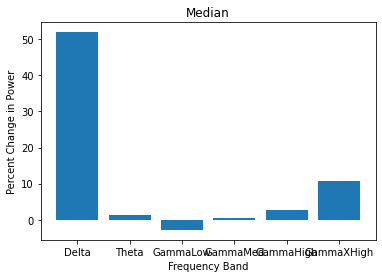

In [9]:
relevant_cols = rearranged.loc[:,'Delta_pct':'GammaXHigh_pct']
fig, ax = plt.subplots()
ax.bar(np.arange(len(freqs)), relevant_cols.median())
ax.set_xticks(np.arange(len(freqs)))
ax.set_xticklabels(freqs)
ax.set_xlabel('Frequency Band')
ax.set_ylabel('Percent Change in Power')
ax.set_title('Median')
fig

This bar graph is a good summary of the data, but I want to get to know my data a bit better, so I'm going to look at a histogram to see more of the individual data points.

In [10]:
power_log_chg = rearranged.copy()
for freq in freqs:
    power_log_chg = power_log_chg.drop(freq+'_pct', axis=1)
    power_log_chg[freq+'_log_chg'] = np.log10(rearranged[freq+'_post']) - np.log10(rearranged[freq+'_pre'])
power_log_chg = power_log_chg.drop('Stim_Num_pre', axis=1).rename({'Stim_Num_post': 'Stim_Num'}, axis=1)
power_log_chg

ID Trial        Channel    Delta_post    Theta_post  GammaLow_post  \
0    100     1  LHip1 - LHip2  1.142265e-07  7.160084e-08   9.921538e-10   
1    100     1  LHip1 - LHip2  5.835607e-08  3.228236e-08   1.174717e-09   
2    100     1  LHip1 - LHip2  5.101219e-08  3.539530e-08   9.132759e-10   
3    100     1  LHip1 - LHip2  8.637263e-08  8.009507e-08   5.182578e-10   
4    100     1  LHip3 - LHip4  3.783933e-07  7.525865e-08   7.594196e-10   
..   ...   ...            ...           ...           ...            ...   
443  115     3  RHip1 - RHip2  9.710153e-08  5.704938e-08   1.300694e-10   
444  115     3  RHip3 - RHip4  1.015435e-07  2.902098e-08   1.991359e-10   
445  115     3  RHip3 - RHip4  3.798745e-08  1.329782e-08   1.610107e-10   
446  115     3  RHip3 - RHip4  9.363271e-08  3.897587e-08   3.496571e-10   
447  115     3  RHip3 - RHip4  9.522910e-08  4.835513e-08   1.603349e-10   

     GammaMed_post  GammaHigh_post  GammaXHigh_post    Alpha_post  ...  \
0     4.940207e-10    9.829770e-11     4.085140e-11  2.537739e-08  ...   
1     3.131012e-10    1.467104e-10     3.619705e-11  2.086106e-08  ...   
2     2.502662e-10    1.111956e-10     2.223456e-11  3.576351e-08  ...   
3     2.529154e-10    8.058721e-11     4.343609e-11  4.598535e-08  ...   
4     1.359819e-10    8.057761e-11     2.862910e-11  5.945015e-09  ...   
..             ...             ...              ...           ...  ...   
443   4.873521e-11    8.070271e-12     6.551630e-12  2.026179e-08  ...   
444   4.883452e-11    1.613729e-11     1.043151e-11  3.395587e-09  ...   
445   3.660184e-11    1.480987e-11     7.810272e-12  2.843842e-09  ...   
446   6.268967e-11    1.797880e-11     8.771414e-12  1.177354e-08  ...   
447   3.522431e-11    1.273296e-11     7.681334e-12  8.531587e-09  ...   

     GammaHigh_pre  GammaXHigh_pre     Alpha_pre      Beta_pre  Delta_log_chg  \
0     1.339650e-10    3.154425e-11  3.897323e-08  1.350544e-08       0.172668   
1     1.339650e-10    3.154425e-11  3.897323e-08  1.350544e-08      -0.119013   
2     1.339650e-10    3.154425e-11  3.897323e-08  1.350544e-08      -0.177425   
3     1.339650e-10    3.154425e-11  3.897323e-08  1.350544e-08       0.051277   
4     5.143055e-11    2.134317e-11  7.956121e-09  3.615258e-09       0.697213   
..             ...             ...           ...           ...            ...   
443   1.402851e-11    7.640572e-12  7.871474e-09  1.820497e-09       0.181488   
444   1.750674e-11    8.461832e-12  4.737566e-09  1.855219e-09       0.232048   
445   1.750674e-11    8.461832e-12  4.737566e-09  1.855219e-09      -0.194964   
446   1.750674e-11    8.461832e-12  4.737566e-09  1.855219e-09       0.196823   
447   1.750674e-11    8.461832e-12  4.737566e-09  1.855219e-09       0.204165   

     Theta_log_chg  GammaLow_log_chg  GammaMed_log_chg  GammaHigh_log_chg  \
0        -0.046214         -0.003213          0.110605          -0.134448   
1        -0.392167          0.070141         -0.087455           0.039469   
2        -0.352187         -0.039190         -0.184738          -0.080904   
3         0.002473         -0.285246         -0.180165          -0.220725   
4         0.141379          0.001054          0.063666           0.194993   
..             ...               ...               ...                ...   
443       0.656793         -0.055679          0.187229          -0.240124   
444       0.275848         -0.210651          0.117204          -0.035375   
445      -0.063084         -0.302946         -0.008020          -0.072654   
446       0.403931          0.033841          0.225673           0.011555   
447       0.497578         -0.304773         -0.024681          -0.138276   

     GammaXHigh_log_chg  
0              0.112287  
1              0.059753  
2             -0.151892  
3              0.138930  
4              0.127549  
..                  ...  
443           -0.066776  
444            0.090883  
445           -0.034798  
446            0.015605  
447           -0.042

In [11]:
power_log_chg.to_csv('power_log_chg.csv', index=False)

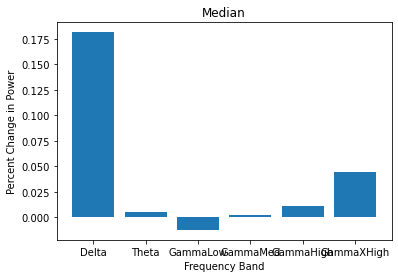

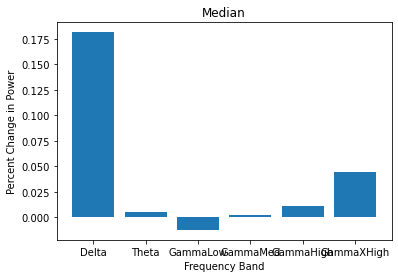

In [12]:
relevant_cols = power_log_chg.loc[:,'Delta_log_chg':'GammaXHigh_log_chg']
fig, ax = plt.subplots()
ax.bar(np.arange(len(freqs)), relevant_cols.median())
ax.set_xticks(np.arange(len(freqs)))
ax.set_xticklabels(freqs)
ax.set_xlabel('Frequency Band')
ax.set_ylabel('Percent Change in Power')
ax.set_title('Median')
fig

Huh, same exact shape as the percent changes. I probably should have expected that. What about the boxplot?

<AxesSubplot:>

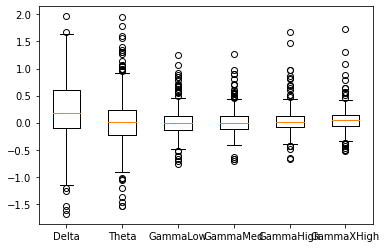

In [13]:
fig, ax = plt.subplots()
ax.boxplot(power_log_chg.loc[:,'Delta_log_chg':'GammaXHigh_log_chg'])
ax.set_xticklabels(freqs)
ax

Okay, so it *does* make a difference on the boxplot. Now we have a much more even distribution of positive and negative changes, which lets us see more clearly that there doesn't seem to be a huge change in the power immediately after stimulation. Well, that's boring. Is the whole project dead in the water here? I suppose we could still try stratifying based on channel/location. And we can also look at each individual patient to see if some people consistently react positively and others consistently react negatively. Let's start by looking at the boxplots for each channel, since that's the easiest analyssis to do and also the easiest to interpret.

As you can see, all of the other channels only have 12 entries, which is to say that they were only recorded for one patient. We can't draw any conclusions about stimulation in a given brain region based on data from one patient, so we'll look at that data when we get to the patient-by-patient analysis. For now, let's confirm the channel-level effect by plotting PSDs and evoked potentials.

In [14]:
raise Exception()

Exception: 

## PSD  Peaks

In [ ]:
mne.set_log_level('WARNING')
pre_epochs_master = []
for pt_num in range(110, 116):
    if pt_num == 114:
        continue
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=1, tmin=0, tmax=1, baseline=(0.5,1.0))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    print(pt_num, epochs.info['ch_names'])
    pre_epochs_master.append(epochs)

110 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
111 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
112 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
113 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
115 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']


c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


C:\Users\seand\AppData\Local\Temp/ipykernel_18916/3542787203.py:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


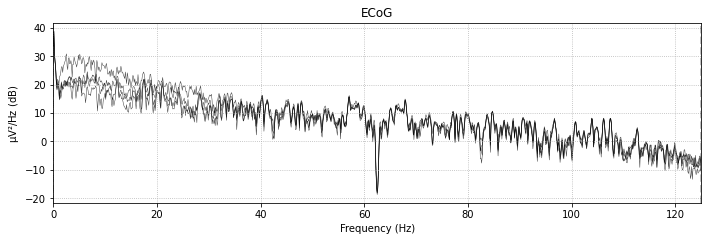

110 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']


C:\Users\seand\AppData\Local\Temp/ipykernel_18916/3542787203.py:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


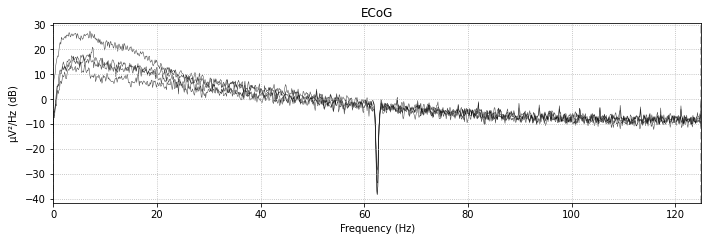

111 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']


C:\Users\seand\AppData\Local\Temp/ipykernel_18916/3542787203.py:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


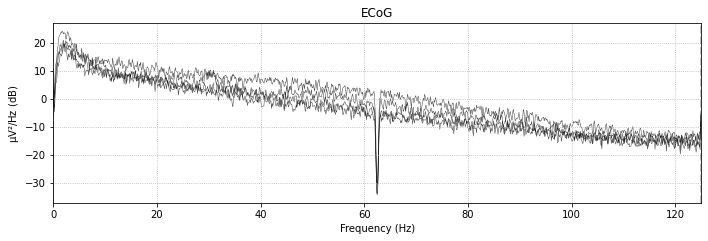

112 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']


C:\Users\seand\AppData\Local\Temp/ipykernel_18916/3542787203.py:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


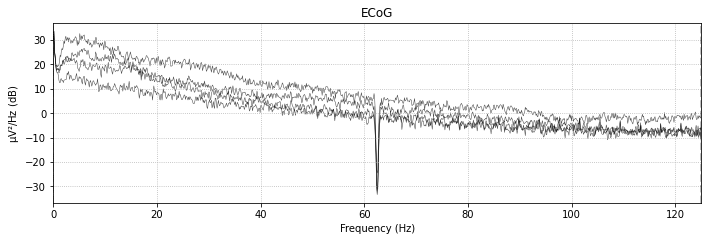

113 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']


c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)
C:\Users\seand\AppData\Local\Temp/ipykernel_18916/3542787203.py:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


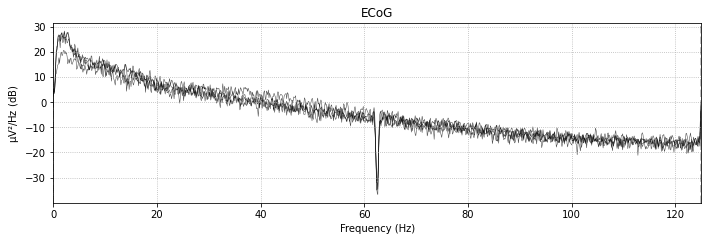

115 ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']


In [ ]:
post_epochs_master = []
for pt_num in range(110, 116):
    if pt_num == 114:
        continue
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=2, tmin=0, tmax=1, baseline=(0.5,1.0))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    print(pt_num, epochs.info['ch_names'])
    post_epochs_master.append(epochs)

In [ ]:
pre_epochs = mne.concatenate_epochs(pre_epochs_master)
post_epochs = mne.concatenate_epochs(post_epochs_master)

In [ ]:
pre_psds, pre_freqs = mne.time_frequency.psd_array_multitaper(pre_epochs.get_data(), pre_epochs.info['sfreq'])
post_psds, post_freqs = mne.time_frequency.psd_array_multitaper(post_epochs.get_data(), post_epochs.info['sfreq'])

In [ ]:
peak_freqs = []
for chan in range(4):
    psd_chan = pre_psds.mean(axis=0)[chan]
    idx, mag = mne.preprocessing.peak_finder(psd_chan, (psd_chan.max() - psd_chan.min()) / 100000)
    peak_freqs.append(pre_freqs[idx])

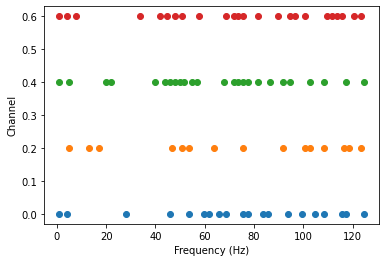

In [ ]:
fig, ax = plt.subplots()
for i in range(4):
    ax.scatter(*[*zip(*[(freq, 0.2*i) for freq in peak_freqs[i]])])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Channel')

```
[  0.99601594   3.98406375  27.88844622  53.78486056  61.75298805
  75.69721116 115.53784861]
[  4.98007968  12.94820717  16.93227092  50.79681275  53.78486056
  59.76095618  63.74501992  75.69721116  91.63346614 108.56573705
 123.5059761 ]
[  0.99601594   4.98007968  19.92031873  21.9123506   39.84063745
  43.8247012   45.81673307  47.80876494  49.80079681  51.79282869
  54.78087649  56.77290837  91.63346614 124.50199203]
[  0.99601594   3.98406375   7.96812749  33.86454183  41.83266932
  44.82071713  47.80876494  50.79681275  58.76494024  68.7250996
  71.71314741  73.70517928  75.69721116  89.64143426  96.61354582
 120.51792829]
 ```

Okay, based on these results, the ranges I want to go for are:
1. Delta - around 0.99601594 (x3)
2. Theta - range that includes 3.98406375 (x2) and 4.98007968 (x2)
3. Alpha - range that includes 7.96812749 (x1)
4. Beta  - range that includes  TODO

I also determined that patients 112 and 115 have the peaks at 62.5 Hz, which is interestingly exactly 1/4 of the sample frequency. It could be due to some sampling error, or a power-line frequency, but either way, I'm going to notch-filter it for now. One question is whether I should notch-filter it for everyone or only for the people who have the peak there (112 and 115, all 4 channels). I think the latter makes more sense, so I'll do that for now and change it if John tells me to.

Nvm, I'm going to need to notch-filter for everyone. Otherwise, some people will have a giant hole and others won't. Or actually, I could just pick my frequency bands to avoid the 62.5 Hz range, and then it won't matter whether or not I notch-filter.

I think I'll get more accurate frequency bands if I look at the peaks for each individual patient, rather than looking at the average of everyone together, So I'm going to try that next:

In [ ]:
epochs_master = pre_epochs_master.copy()
for post_epoch in post_epochs_master:
    epochs_master.append(post_epoch)

In [ ]:
peak_freqs = []
for epoch in epochs_master:
    for chan in range(4):
        psds, freqs = mne.time_frequency.psd_array_multitaper(epoch.get_data(), epoch.info['sfreq'])
        psd_chan = psds.mean(axis=0)[chan]
        idx, mag = mne.preprocessing.peak_finder(psd_chan, (psd_chan.max() - psd_chan.min()) / 100000)
        peak_freqs.append(freqs[idx])

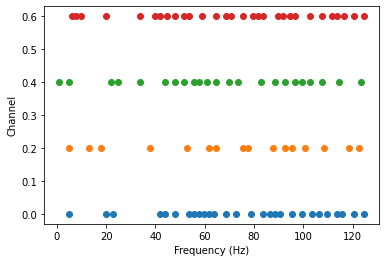

In [ ]:
fig, ax = plt.subplots()
for i in range(4):
    ax.scatter(*[*zip(*[(freq, 0.2*i) for freq in peak_freqs[i]])])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Channel')

Well, there are certainly more peaks to work with. Now that I think about it, using the difference between the post and pre-stim epochs would probably give me even more useful data to work with, so let's try that next

In [ ]:
peak_freqs = []
for chan in range(4):
    pre_psd_chan = pre_psds.mean(axis=0)[chan]
    post_psd_chan = post_psds.mean(axis=0)[chan]
    psd_chan = post_psd_chan - pre_psd_chan
    idx, mag = mne.preprocessing.peak_finder(psd_chan, (psd_chan.max() - psd_chan.min()) / 100000)
    peak_freqs.append(freqs[idx])

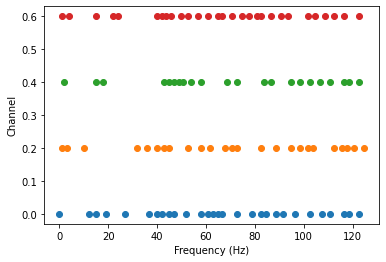

In [ ]:
fig, ax = plt.subplots()
for i in range(4):
    ax.scatter(*[*zip(*[(freq, 0.2*i) for freq in peak_freqs[i]])])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Channel')

I think I'll go with this last one for selecting frequency bands. Next, let's algorithmically pick the highest-yield frequency bands

In [ ]:
def merge(arr1, arr2):
    arr3 = [None] * (len(arr1) + len(arr2))
    i = 0
    j = 0
    k = 0

    while i < len(arr1) and j < len(arr2):
        if arr1[i] < arr2[j]:
            arr3[k] = arr1[i]
            i += 1
        else:
            arr3[k] = arr2[j]
            j += 1
        k += 1

    while i < len(arr1):
        arr3[k] = arr1[i]
        i += 1
        k += 1
    while j < len(arr2):
        arr3[k] = arr2[j]
        j += 1
        k += 1
    
    return arr3

In [ ]:
sorted_peak_freqs = merge(merge(merge(peak_freqs[0], peak_freqs[1]), peak_freqs[2]), peak_freqs[3])

In [ ]:
band_start = 0.0
start_idx = 0
peak_counts = dict()
for idx, freq in enumerate(sorted_peak_freqs):
    # if we are past the end of a band
    if freq - band_start >= 5.0:
        # count how many peaks there were in that band
        num_peaks = idx - start_idx
        # mark it down in our peak_counts, which maps the band start to the number of peaks
        peak_counts[band_start] = num_peaks
        # move the band start forward to the next frequency that isn't the same as the one we just did
        new_start = start_idx + 1
        while sorted_peak_freqs[new_start] == band_start:
            new_start += 1
        start_idx = new_start
        band_start = sorted_peak_freqs[new_start]
    # if we're still within a 5 Hz band, we can just keep moving forward

In [ ]:
reverse_sorted_freqs = sorted(peak_counts, key=peak_counts.get)
reverse_sorted_freqs.reverse()

In [ ]:
peaks_to_use = []
for freq in reverse_sorted_freqs:
    should_add = True
    for existing_freq in peaks_to_use:
        if abs(freq - existing_freq) < 5.0:
            should_add = False
    
    if should_add:
        peaks_to_use.append(freq)
peaks_to_use

[41.832669322709165,
 116.53386454183267,
 101.59362549800797,
 82.66932270916335,
 70.71713147410358,
 57.76892430278885,
 51.79282868525897,
 110.55776892430279,
 94.62151394422311,
 64.7410358565737,
 0.9960159362549801,
 88.64541832669323,
 35.85657370517929,
 14.9402390438247,
 26.89243027888446]

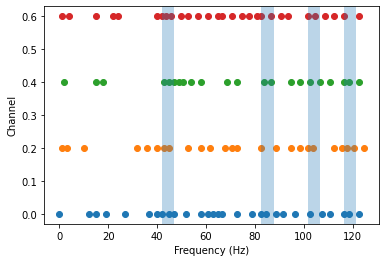

In [ ]:
fig, ax = plt.subplots()
for i in range(4):
    ax.scatter(*[*zip(*[(freq, 0.2*i) for freq in peak_freqs[i]])])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Channel')
for freq in peaks_to_use[:4]:
    ax.axvspan(freq, freq + 5.0, alpha=0.3)

## Stats

The basic idea of this is analysis is to create a bootstrapped dataset, calaculate summary statistics on the bootstrapped dataset, and then use this to get P-values for whether or not there is a statistically significant difference between the pre-shock periods and the post-shock periods. We create our bootstrapped dataset by comparing each stimulation to a randomly selected baseline from the same patient. This baseline could be from a different channel or a different trial, or both. These random selections are performed with replacement because I see no reason not to. I elected to use medians as my summary statistic rather than means because we know our data has some positive-skewed outliers.

John said something about performing a t-test on the results. t-test compares means between 2 samples. However, my current method does not provide me with 2 samples, since I subtract the baseline power from the stim power before calculating the median difference. The first problem is that I am using medians instead of means, but I guess I can change that fairly easily. The second problem is that I don't have 2 different datasets to compare, only the one. This aligns with the matched-pair study design, since we are matching each stimulation to a baseline. I suppose this doesn't necessarily have to be true, so we could try putting together 2 separate datasets for the baselines and for the stims. They would have different sample sizes, though, but IIRC the 2-sample t-test can handle that with pooled variance. How would we bootstrap in that case, though? Doesn't the 2-sample t-test already account for the potential variation in the sample mean/median? I watched a video on it, and apparently the 2-sample t-test requires large sample sizes because the t-distribution is only met when the central limit theorem applies. In contrast, bootstrapping works with smaller datasets. I think we can try both approaches and compare the results.

# Memory Correlations

I'm going to try doing these in Excel first, since Pivot Tables generally make it easy to check a bunch of correlations. For that, I'll have to export the data to Excel.

In [ ]:
power_log_chg.to_csv('power_log_chg.csv')

Get memory data

In [16]:
memory_trials = pd.read_csv('memory_trials.csv').iloc[:,1:]
memory_trials = memory_trials.drop(11, axis=0)
memory_trials['ID'] = memory_trials['ID'].astype(int)
memory_trials

ID  Trial_1_Stim  Trial_2_Stim  Trial_3_Stim  Trial_1_Sham  Trial_2_Sham  \
0   100             4             6             6             7             7   
1   101             3             5             6             5             6   
2   102             7            10            11             4             8   
3   103             7             8            10             7             6   
4   104             4             4             6             5             6   
5   105             5             7             7             7             6   
6   106             8            10            12             9            10   
7   107             7            10            10             0             0   
8   108             2             5             7             4             7   
9   109             4             7             9             5             7   
10  110             5             5             7             7             7   
12  112             8             9            10             5             9   
13  113             7             9             9             6             8   
14  115             4             6             5             4             4   
15  200             4             3             5             2             2   
16  201             6             6             7             7             6   
17  202             4             5             7             4             5   
18  205             5             5             6             0             0   
19  206             4             7             7             6             5   
20  207             6             9             9             0             0   
21  208             5             8            11             0             0   
22  209             5             6             8             0             0   

    Trial_3_Sham   Avg_Sham  
0              9   7.666667  
1              9   6.666667  
2              8   6.666667  
3              7   6.666667  
4              5   5.333333  
5              7   6.666667  
6             12  10.333333  
7              0   0.000000  
8              6   5.666667  
9              9   6.666667  
10             8   7.333333  
12             8   7.333333  
13             8   7.333333  
14             7   5.000000  
15             4   2.666667  
16             8   7.000000  
17             7   5.333333  
18             0   0.000000  
19             5   5.333333  
20             0   0.000000  
21             0   0.000000  
22             0   0.000000

In [17]:
memory_trials = memory_trials.set_index(['ID', 'Avg_Sham']).stack().to_frame()
memory_trials['Trial'] = memory_trials.index.get_level_values(2)
memory_trials['Trial'] = memory_trials['Trial'].str[len('Trial_')].astype(int)
memory_trials = memory_trials.reset_index(level=2)
memory_trials = memory_trials[~memory_trials['level_2'].str.endswith('Sham')]
memory_trials = memory_trials.drop('level_2', axis=1)
memory_trials = memory_trials.rename(columns={0: 'Memory_Score'})
memory_trials = memory_trials.reset_index(level=1)
memory_trials

Avg_Sham  Memory_Score  Trial
ID                                
100  7.666667             4      1
100  7.666667             6      2
100  7.666667             6      3
101  6.666667             3      1
101  6.666667             5      2
..        ...           ...    ...
208  0.000000             8      2
208  0.000000            11      3
209  0.000000             5      1
209  0.000000             6      2
209  0.000000             8      3

[66 rows x 3 columns]

In [18]:
power_and_mem = power_log_chg.merge(memory_trials, on=['ID', 'Trial'], how='left')

In [19]:
power_and_mem = power_and_mem.dropna()

NOTE: the delay data is currently excluding pt 111 because his trials were dropped in the above cell. Technically, the delay data could use 111, but he is an extreme outlier, so I'll leave it alone for now.

In [20]:
memory_delayed = pd.read_csv('memory_delayed.csv').iloc[:,1:]
memory_delayed = memory_delayed.rename({'Memory_Stim': 'Delay_Mem_Stim', 'Memory_Sham': 'Delay_Mem_Sham'}, axis=1)
power_and_mem = power_and_mem.merge(memory_delayed, on='ID', how='left')

temp

In [21]:
power_and_mem

ID Trial        Channel    Delta_post    Theta_post  GammaLow_post  \
0    100     1  LHip1 - LHip2  1.142265e-07  7.160084e-08   9.921538e-10   
1    100     1  LHip1 - LHip2  5.835607e-08  3.228236e-08   1.174717e-09   
2    100     1  LHip1 - LHip2  5.101219e-08  3.539530e-08   9.132759e-10   
3    100     1  LHip1 - LHip2  8.637263e-08  8.009507e-08   5.182578e-10   
4    100     1  LHip3 - LHip4  3.783933e-07  7.525865e-08   7.594196e-10   
..   ...   ...            ...           ...           ...            ...   
411  115     3  RHip1 - RHip2  9.710153e-08  5.704938e-08   1.300694e-10   
412  115     3  RHip3 - RHip4  1.015435e-07  2.902098e-08   1.991359e-10   
413  115     3  RHip3 - RHip4  3.798745e-08  1.329782e-08   1.610107e-10   
414  115     3  RHip3 - RHip4  9.363271e-08  3.897587e-08   3.496571e-10   
415  115     3  RHip3 - RHip4  9.522910e-08  4.835513e-08   1.603349e-10   

     GammaMed_post  GammaHigh_post  GammaXHigh_post    Alpha_post  ...  \
0     4.940207e-10    9.829770e-11     4.085140e-11  2.537739e-08  ...   
1     3.131012e-10    1.467104e-10     3.619705e-11  2.086106e-08  ...   
2     2.502662e-10    1.111956e-10     2.223456e-11  3.576351e-08  ...   
3     2.529154e-10    8.058721e-11     4.343609e-11  4.598535e-08  ...   
4     1.359819e-10    8.057761e-11     2.862910e-11  5.945015e-09  ...   
..             ...             ...              ...           ...  ...   
411   4.873521e-11    8.070271e-12     6.551630e-12  2.026179e-08  ...   
412   4.883452e-11    1.613729e-11     1.043151e-11  3.395587e-09  ...   
413   3.660184e-11    1.480987e-11     7.810272e-12  2.843842e-09  ...   
414   6.268967e-11    1.797880e-11     8.771414e-12  1.177354e-08  ...   
415   3.522431e-11    1.273296e-11     7.681334e-12  8.531587e-09  ...   

     Delta_log_chg  Theta_log_chg  GammaLow_log_chg  GammaMed_log_chg  \
0         0.172668      -0.046214         -0.003213          0.110605   
1        -0.119013      -0.392167          0.070141         -0.087455   
2        -0.177425      -0.352187         -0.039190         -0.184738   
3         0.051277       0.002473         -0.285246         -0.180165   
4         0.697213       0.141379          0.001054          0.063666   
..             ...            ...               ...               ...   
411       0.181488       0.656793         -0.055679          0.187229   
412       0.232048       0.275848         -0.210651          0.117204   
413      -0.194964      -0.063084         -0.302946         -0.008020   
414       0.196823       0.403931          0.033841          0.225673   
415       0.204165       0.497578         -0.304773         -0.024681   

     GammaHigh_log_chg  GammaXHigh_log_chg  Avg_Sham  Memory_Score  \
0            -0.134448            0.112287  7.666667           4.0   
1             0.039469            0.059753  7.666667           4.0   
2            -0.080904           -0.151892  7.666667           4.0   
3            -0.220725            0.138930  7.666667           4.0   
4             0.194993            0.127549  7.666667           4.0   
..                 ...                 ...       ...           ...   
411          -0.240124           -0.066776  5.000000           5.0   
412          -0.035375            0.090883  5.000000           5.0   
413          -0.072654           -0.034798  5.000000           5.0   
414           0.011555            0.015605  5.000000           5.0   
415          -0.138276           -0.042028  5.000000           5.0   

     Delay_Mem_Stim  Delay_Mem_Sham  
0               4.0               5  
1               4.0               5  
2               4.0               5  
3               4.0               5  
4               4.0               5  
..              ...             ...  
411             4.0               5  
412             4.0               5  
413             4.0               5  
414             4.0               5  
415             4.0               5  

[416 rows x 30 columns]

## Pipeline

In [22]:
from stats_pipeline import do_stats

In [23]:
from sklearn.linear_model import LinearRegression
f1 = power_and_mem[power_and_mem['Channel'] == 'LHip3 - LHip4'][['ID', 'Trial', 'Delta_post']].groupby(by=['ID', 'Trial']).mean()
f2 = power_and_mem[power_and_mem['Channel'] == 'LHip3 - LHip4'][['ID', 'Trial', 'Theta_post']].groupby(by=['ID', 'Trial']).mean()
f3 = power_and_mem[power_and_mem['Channel'] == 'LHip3 - LHip4'][['ID', 'Trial', 'GammaXHigh_log_chg']].groupby(by=['ID', 'Trial']).mean()
f4 = power_and_mem[power_and_mem['Channel'] == 'LHip3 - LHip4'][['ID', 'Trial', 'Memory_Score', 'Avg_Sham']].groupby(by=['ID', 'Trial']).mean()

features = f1.merge(f2, left_index=True, right_index=True) \
             .merge(f3, left_index=True, right_index=True) \
             .merge(f4, left_index=True, right_index=True) \
             .reset_index()
model = LinearRegression()

X = features[['Delta_post', 'Theta_post', 'GammaXHigh_log_chg', 'ID']]
Y = features['Memory_Score'] - features['Avg_Sham']
model.fit(X, Y)
model.score(X, Y)

0.5455008012674188

In [24]:
col = 'ID'
model.fit(X[[col]], Y)
model.score(X[[col]], Y)

0.31339673423578107

In [25]:
col = 'Delta_post'
model.fit(X[[col]], Y)
model.score(X[[col]], Y)

0.5454516651180388

In [26]:
col = 'Theta_post'
model.fit(X[[col]], Y)
model.score(X[[col]], Y)

0.22599146146201277

Text(0.5, 0, 'Feature')

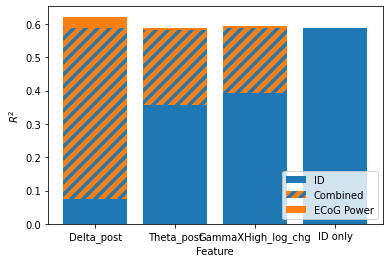

In [64]:
fig, ax = plt.subplots()

cols = ['Delta_post', 'Theta_post', 'GammaXHigh_log_chg']

model.fit(pd.get_dummies(X['ID']), Y)
id_only = model.score(pd.get_dummies(X['ID']), Y)
col_only = []
col_id = []
for col in cols:
    model.fit(X[[col]], Y)
    col_only.append(model.score(X[[col]], Y))
    x_id = pd.get_dummies(X['ID'])
    x_id[col] = X[col]
    x_id = x_id.rename(lambda x: str(x), axis='columns')
    model.fit(x_id, Y)
    col_id.append(model.score(x_id, Y))

col_only = np.array(col_only)
col_id = np.array(col_id)

ax.bar(cols, col_id - col_only, color='tab:blue')
plt.rc('hatch', color='tab:orange', linewidth=5)
ax.bar(cols, id_only - (col_id - col_only), bottom=col_id - col_only, hatch='//')
ax.bar(cols, col_id - id_only, bottom=id_only)
ax.bar('ID only', id_only, color='tab:blue')

ax.legend(['ID', 'Combined', 'ECoG Power'])
ax.set_ylabel('$R^2$')
ax.set_xlabel('Feature')

In [39]:
X['Delta_post']

0     2.543895e-07
1     2.445648e-07
2     1.840807e-07
3     2.213741e-08
4     8.570973e-09
5     1.071476e-08
6     2.038547e-07
7     1.894809e-07
8     1.573170e-07
9     5.627215e-09
10    7.290763e-09
11    5.037543e-09
12    6.750832e-08
13    2.915832e-08
14    3.555364e-08
15    1.110688e-08
16    1.708718e-08
17    1.765250e-08
Name: Delta_post, dtype: float64

## Trial Memory Raw vs Power Post

In [28]:
# import importlib
# import stats_pipeline
# importlib.reload(stats_pipeline)
from stats_pipeline import do_stats

Averaging across stims in the same patient, channel, and trial


Channel   Frequency         r         P
0   LHip1 - LHip2       Delta -0.197209  0.432822
1   LHip1 - LHip2       Theta -0.361427  0.140568
2   LHip1 - LHip2    GammaLow -0.085513  0.735837
3   LHip1 - LHip2    GammaMed  0.058701  0.817030
4   LHip1 - LHip2   GammaHigh -0.388614  0.110987
5   LHip1 - LHip2  GammaXHigh -0.302500  0.222426
6   LHip3 - LHip4       Delta -0.734875  0.000513
7   LHip3 - LHip4       Theta -0.693909  0.001401
8   LHip3 - LHip4    GammaLow -0.533040  0.022739
9   LHip3 - LHip4    GammaMed -0.182668  0.468148
10  LHip3 - LHip4   GammaHigh -0.389738  0.109869
11  LHip3 - LHip4  GammaXHigh -0.320383  0.194915
12  RHip1 - RHip2       Delta  0.163818  0.515993
13  RHip1 - RHip2       Theta  0.120163  0.634832
14  RHip1 - RHip2    GammaLow  0.212055  0.398248
15  RHip1 - RHip2    GammaMed  0.261983  0.293632
16  RHip1 - RHip2   GammaHigh  0.152374  0.546110
17  RHip1 - RHip2  GammaXHigh  0.015466  0.951432
18  RHip3 - RHip4       Delta  0.080069  0.776673
19  RHip3 - RHip4       Theta -0.020115  0.943275
20  RHip3 - RHip4    GammaLow  0.152367  0.587748
21  RHip3 - RHip4    GammaMed  0.027291  0.923089
22  RHip3 - RHip4   GammaHigh -0.195611  0.484758
23  RHip3 - RHip4  GammaXHigh -0.319261  0.246090

Linear regression:


Frequency         Delta     Theta  GammaLow  GammaMed  GammaHigh  GammaXHigh
Channel                                                                     
LHip1 - LHip2  0.819165  0.562274  0.929478  0.933749   0.532739    0.656241
LHip3 - LHip4  0.012306  0.016816  0.181911  0.819165   0.532739    0.656241
RHip1 - RHip2  0.819165  0.846442  0.819165  0.704717   0.819165    0.951432
RHip3 - RHip4  0.932007  0.951432  0.829761  0.951432   0.819165    0.656241

Fisher Exact:


Frequency      Delta  Theta  GammaLow  GammaMed  GammaHigh  GammaXHigh
Channel                                                               
LHip1 - LHip2    1.0    1.0       1.0       1.0        1.0         1.0
LHip3 - LHip4    1.0    1.0       1.0       1.0        1.0         1.0
RHip1 - RHip2    1.0    1.0       1.0       1.0        1.0         1.0
RHip3 - RHip4    1.0    1.0       1.0       1.0        1.0         1.0

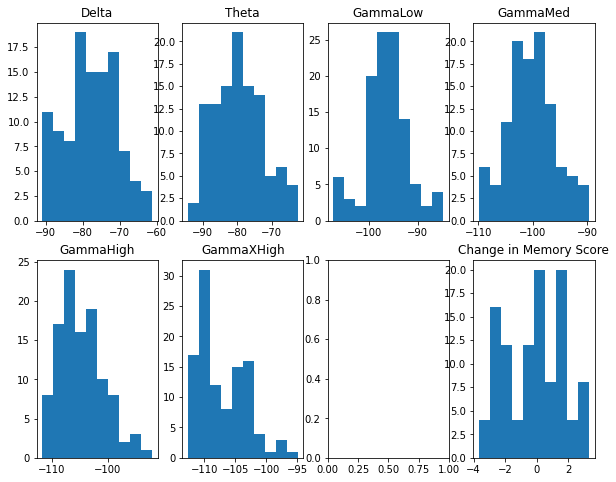

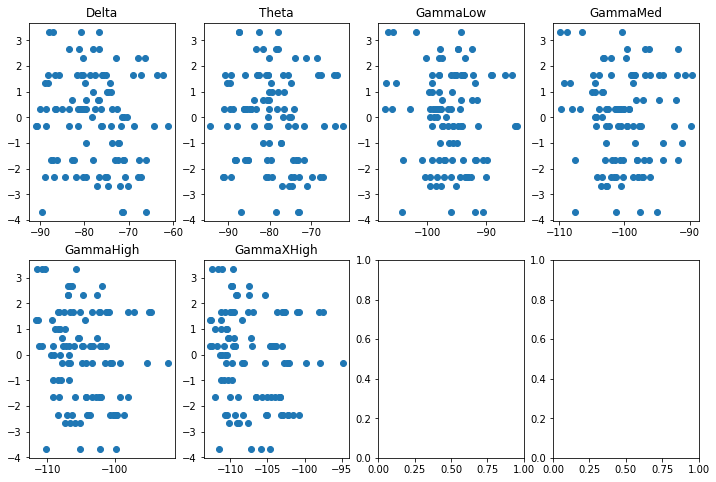

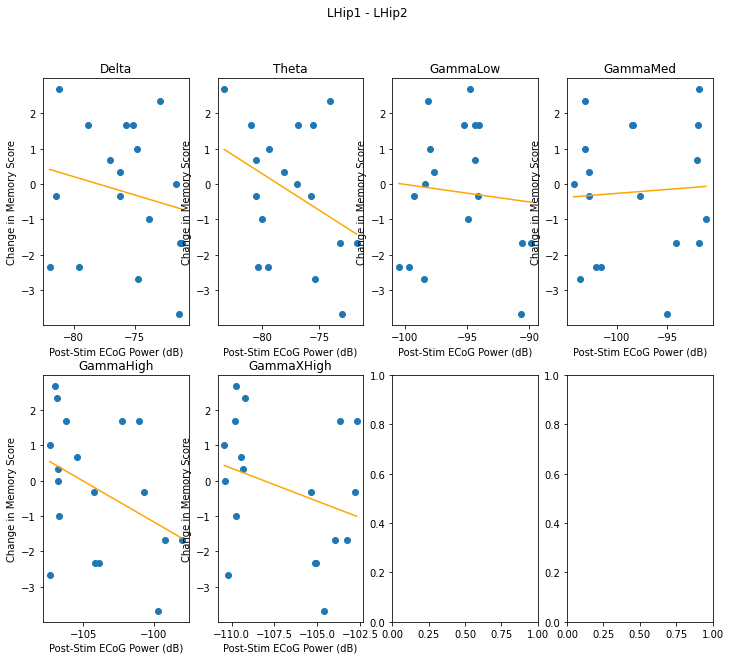

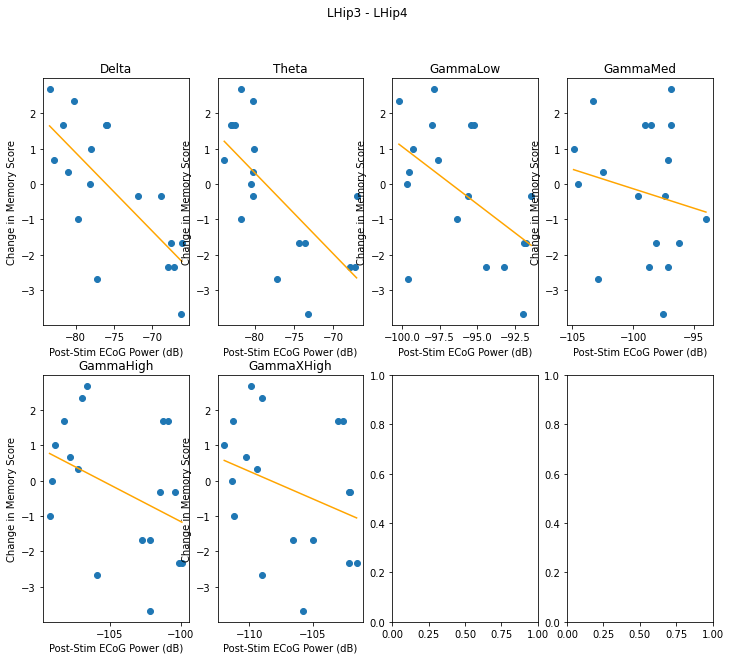

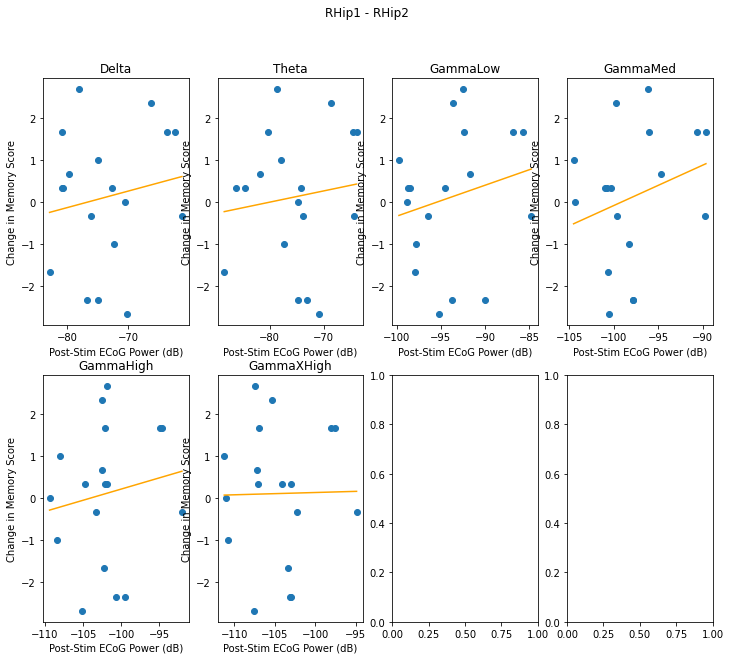

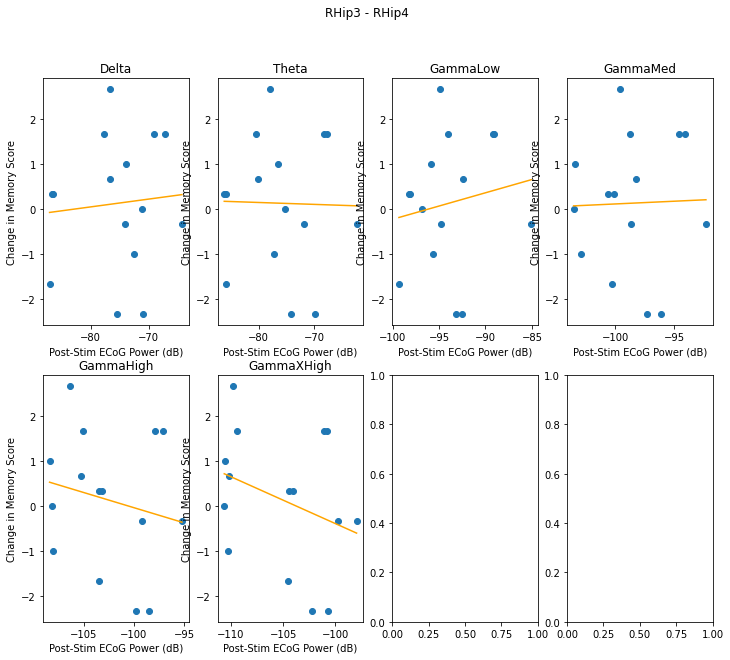

In [29]:
do_stats(power_and_mem, '10 * log($FREQ_post) / log(10)', 'Memory_Score - Avg_Sham', 'Post-Stim ECoG Power (dB)', 'Change in Memory Score', show_all_p=True, freqs=['Delta', 'Theta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh'])

In [30]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Avg_Sham', 'Change in ECoG Power (dB)', 'Baseline Memory Score', mem_null_hyp=7, freqs=['Delta', 'GammaLow', 'GammaMed', 'GammaHigh'], force_full_avg=True)

TypeError: do_stats() got an unexpected keyword argument 'force_full_avg'

## Trial Memory Chg vs Power Change (averaged)

Averaging across stims in the same patient, channel, and trial
Fisher Exact P-value = 0.33484162895927627 for Theta band in LHip1 - LHip2


Power         
                Decrease Increase
Memory Decrease        7        2
       Increase        4        4

Fisher Exact P-value = 0.34693541752365364 for GammaMed band in LHip1 - LHip2


Power         
                Decrease Increase
Memory Decrease        3        6
       Increase        5        3

Fisher Exact P-value = 0.08235294117647061 for Delta band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        0        9
       Increase        3        5

Fisher Exact P-value = 0.15343480049362435 for GammaLow band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        3        6
       Increase        6        2

Fisher Exact P-value = 0.33484162895927627 for GammaMed band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        4        5
       Increase        6        2

Fisher Exact P-value = 0.15343480049362415 for GammaHigh band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        2        7
       Increase        5        3

Fisher Exact P-value = 0.00904977375565612 for GammaXHigh band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        0        9
       Increase        5        3

Fisher Exact P-value = 0.15343480049362418 for GammaLow band in RHip1 - RHip2


Power         
                Decrease Increase
Memory Decrease        2        5
       Increase        7        3

Fisher Exact P-value = 0.30069930069930034 for GammaLow band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        1        5
       Increase        4        4

Fisher Exact P-value = 0.2087912087912086 for GammaXHigh band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        0        6
       Increase        3        5

Channel   Frequency         r         P
0   LHip1 - LHip2       Delta -0.158230  0.550000
1   LHip1 - LHip2       Theta -0.061225  0.831944
2   LHip1 - LHip2    GammaLow -0.020973  0.943056
3   LHip1 - LHip2    GammaMed -0.383877  0.109722
4   LHip1 - LHip2   GammaHigh -0.207319  0.404167
5   LHip1 - LHip2  GammaXHigh -0.329679  0.168056
6   LHip3 - LHip4       Delta -0.404090  0.109722
7   LHip3 - LHip4       Theta -0.398196  0.102778
8   LHip3 - LHip4    GammaLow -0.075886  0.752778
9   LHip3 - LHip4    GammaMed -0.270490  0.251389
10  LHip3 - LHip4   GammaHigh -0.432490  0.065278
11  LHip3 - LHip4  GammaXHigh -0.448766  0.066667
12  RHip1 - RHip2       Delta  0.142094  0.565278
13  RHip1 - RHip2       Theta  0.159676  0.536111
14  RHip1 - RHip2    GammaLow -0.479002  0.031944
15  RHip1 - RHip2    GammaMed -0.248254  0.301389
16  RHip1 - RHip2   GammaHigh  0.090348  0.704167
17  RHip1 - RHip2  GammaXHigh  0.029845  0.919444
18  RHip3 - RHip4       Delta -0.057302  0.822222
19  RHip3 - RHip4       Theta -0.099752  0.727778
20  RHip3 - RHip4    GammaLow -0.310525  0.237500
21  RHip3 - RHip4    GammaMed -0.548963  0.030556
22  RHip3 - RHip4   GammaHigh -0.243602  0.394444
23  RHip3 - RHip4  GammaXHigh -0.186914  0.480556

Linear regression:


Frequency      Delta  Theta  GammaLow  GammaMed  GammaHigh  GammaXHigh
Channel                                                               
LHip1 - LHip2    NaN    NaN       NaN       NaN        NaN         NaN
LHip3 - LHip4    NaN    NaN       NaN       NaN        NaN         NaN
RHip1 - RHip2    NaN    NaN       NaN       NaN        NaN         NaN
RHip3 - RHip4    NaN    NaN       NaN       NaN        NaN         NaN

Fisher Exact:


Frequency      Delta  Theta  GammaLow  GammaMed  GammaHigh  GammaXHigh
Channel                                                               
LHip1 - LHip2    NaN    NaN       NaN       NaN        NaN         NaN
LHip3 - LHip4    NaN    NaN       NaN       NaN        NaN         NaN
RHip1 - RHip2    NaN    NaN       NaN       NaN        NaN         NaN
RHip3 - RHip4    NaN    NaN       NaN       NaN        NaN         NaN

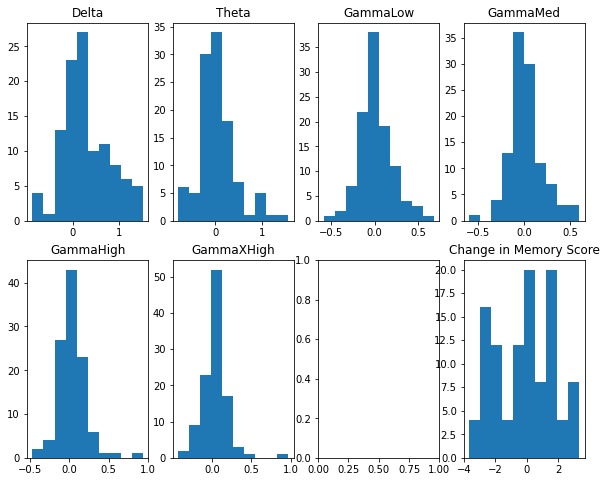

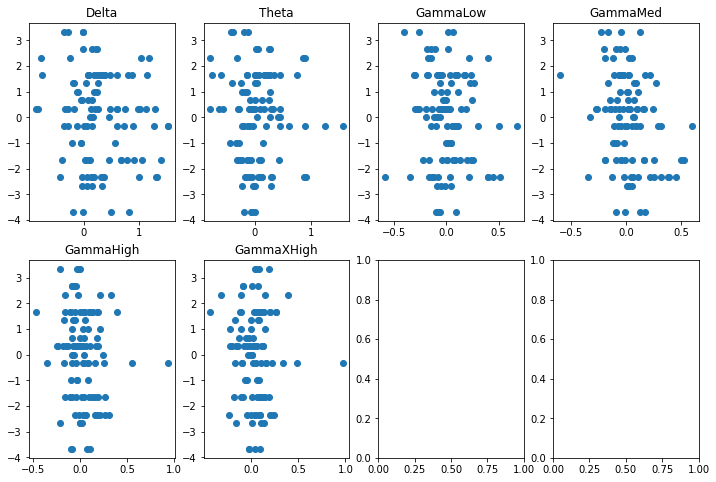

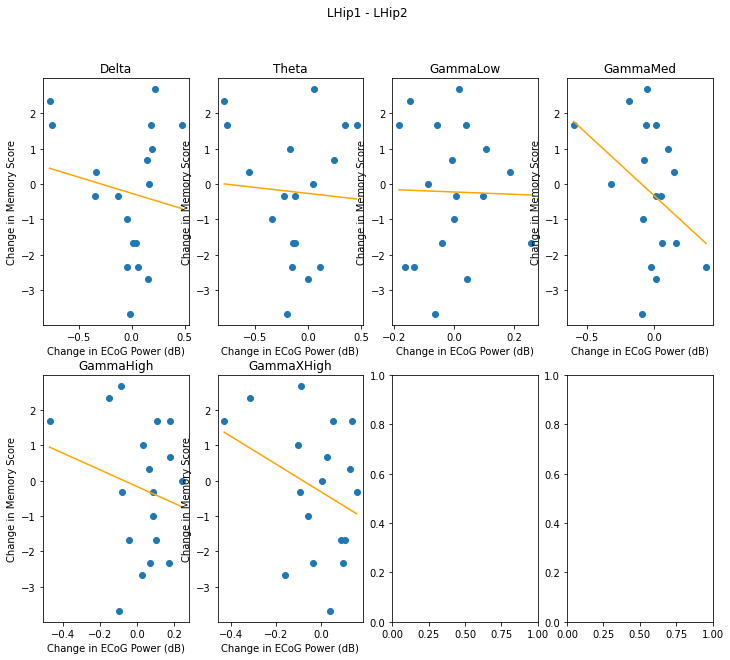

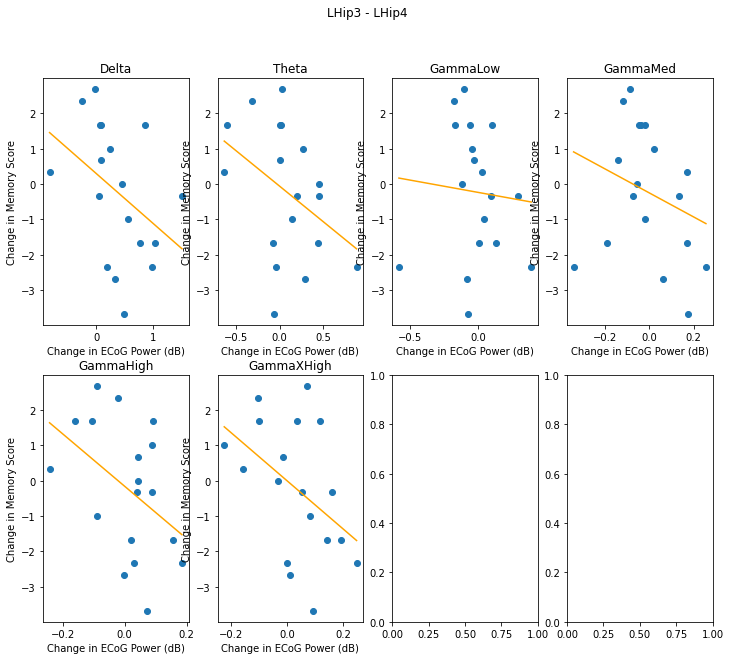

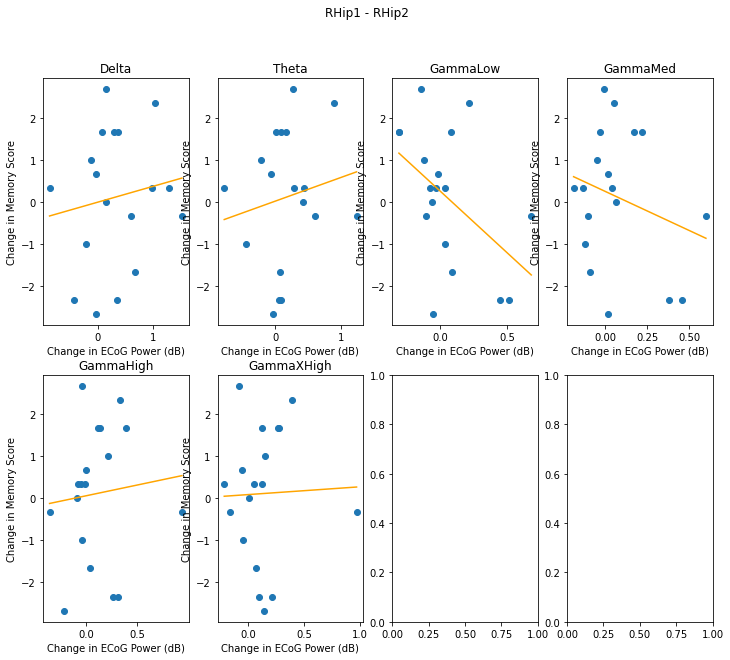

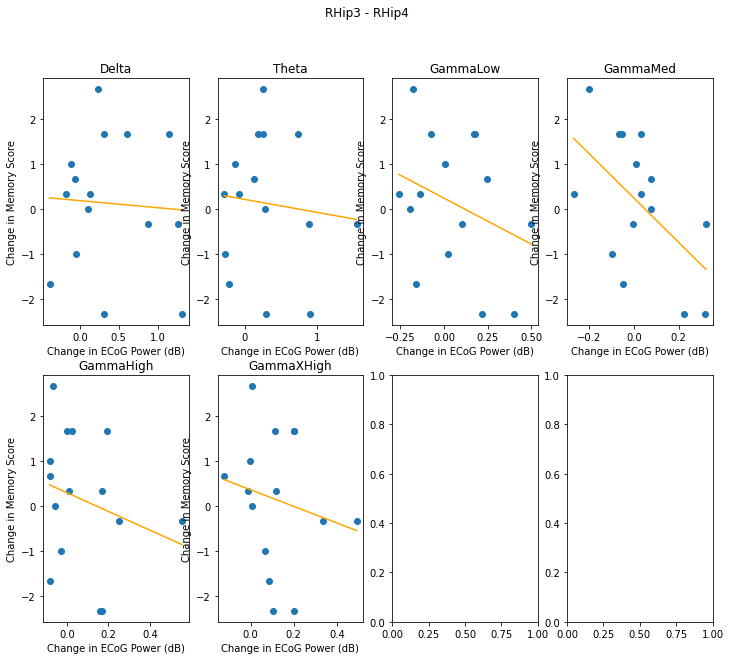

In [ ]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Memory_Score - Avg_Sham', 'Change in ECoG Power (dB)', 'Change in Memory Score', linreg_pval='perm', freqs=['Delta', 'Theta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh'])

Averaging power across all stims in the same patient, channel, and trial
Fisher Exact P-value = 0.08235294117647061 for Delta band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        0        9
       Increase        3        5

Fisher Exact P-value = 0.13122171945701389 for GammaHigh band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        1        8
       Increase        4        4

Fisher Exact P-value = 0.3499588646647469 for GammaLow band in RHip1 - RHip2


Power         
                Decrease Increase
Memory Decrease        3        4
       Increase        7        3

Fisher Exact P-value = 0.13752913752913742 for GammaMed band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        1        5
       Increase        5        3

Fisher Exact P-value = 0.47252747252747207 for GammaHigh band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        0        6
       Increase        2        6

Channel  Frequency         r         P
0   LHip1 - LHip2      Delta -0.143339  0.570429
1   LHip1 - LHip2   GammaLow  0.091450  0.718181
2   LHip1 - LHip2   GammaMed -0.242647  0.331966
3   LHip1 - LHip2  GammaHigh -0.226804  0.365443
4   LHip3 - LHip4      Delta -0.418017  0.084303
5   LHip3 - LHip4   GammaLow -0.067996  0.788637
6   LHip3 - LHip4   GammaMed -0.552875  0.017327
7   LHip3 - LHip4  GammaHigh -0.450314  0.060753
8   RHip1 - RHip2      Delta  0.128088  0.612497
9   RHip1 - RHip2   GammaLow -0.236579  0.344571
10  RHip1 - RHip2   GammaMed -0.039381  0.876708
11  RHip1 - RHip2  GammaHigh -0.064242  0.800074
12  RHip3 - RHip4      Delta -0.104485  0.710952
13  RHip3 - RHip4   GammaLow -0.398315  0.141425
14  RHip3 - RHip4   GammaMed -0.493363  0.061642
15  RHip3 - RHip4  GammaHigh -0.238156  0.392688

Linear regression:


Frequency         Delta  GammaLow  GammaMed  GammaHigh
Channel                                               
LHip1 - LHip2  0.853413  0.853413  0.698112   0.698112
LHip3 - LHip4  0.337212  0.853413  0.277224   0.328760
RHip1 - RHip2  0.853413  0.698112  0.876708   0.853413
RHip3 - RHip4  0.853413  0.452561  0.328760   0.698112

Fisher Exact:


Frequency         Delta  GammaLow  GammaMed  GammaHigh
Channel                                               
LHip1 - LHip2  1.000000       1.0  1.000000   1.000000
LHip3 - LHip4  0.733489       1.0  1.000000   0.733489
RHip1 - RHip2  1.000000       1.0  1.000000   1.000000
RHip3 - RHip4  1.000000       1.0  0.733489   1.000000

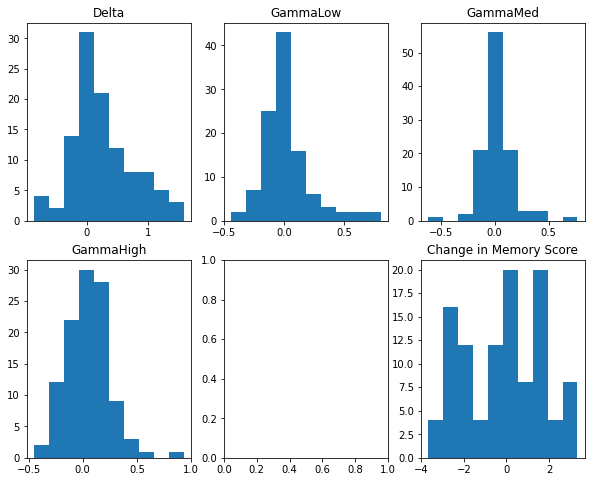

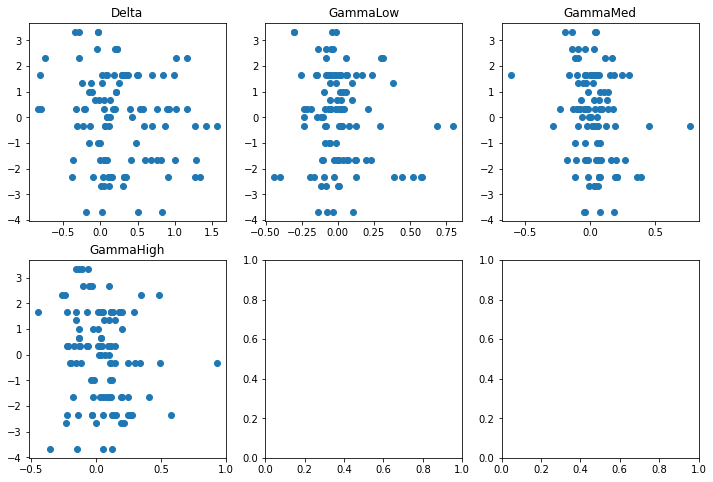

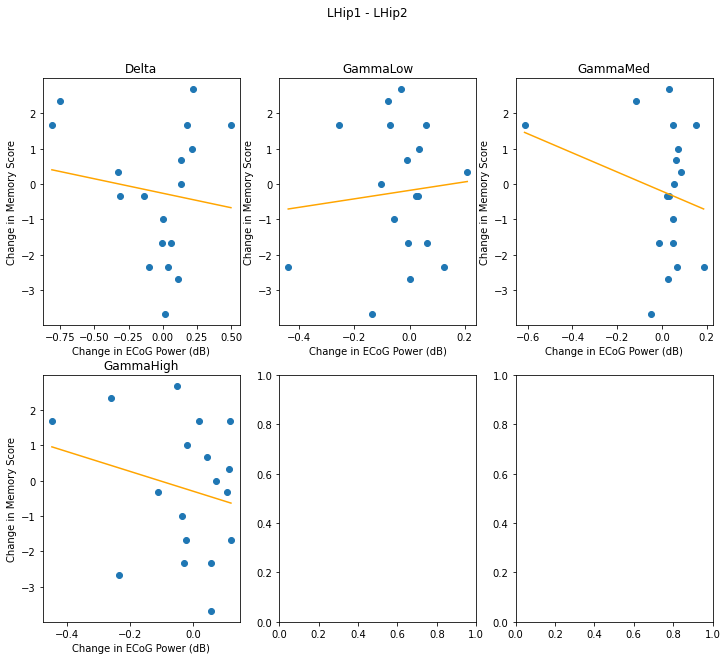

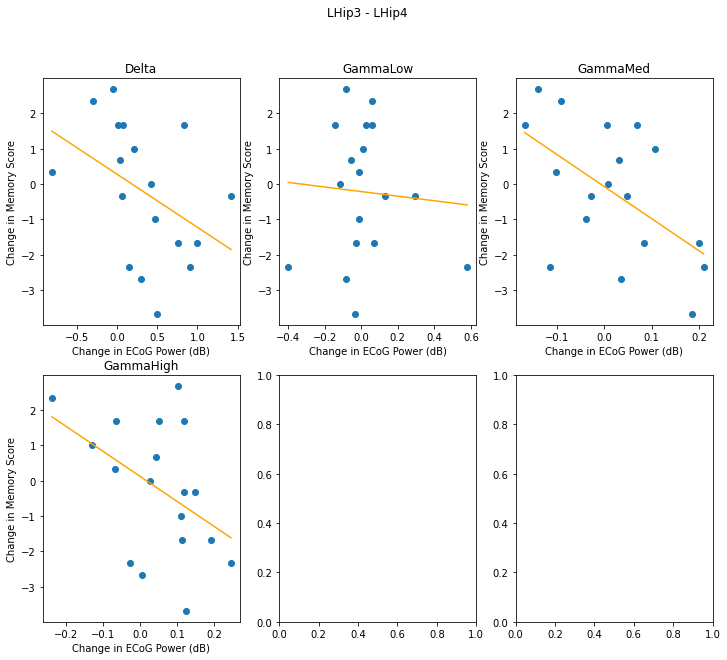

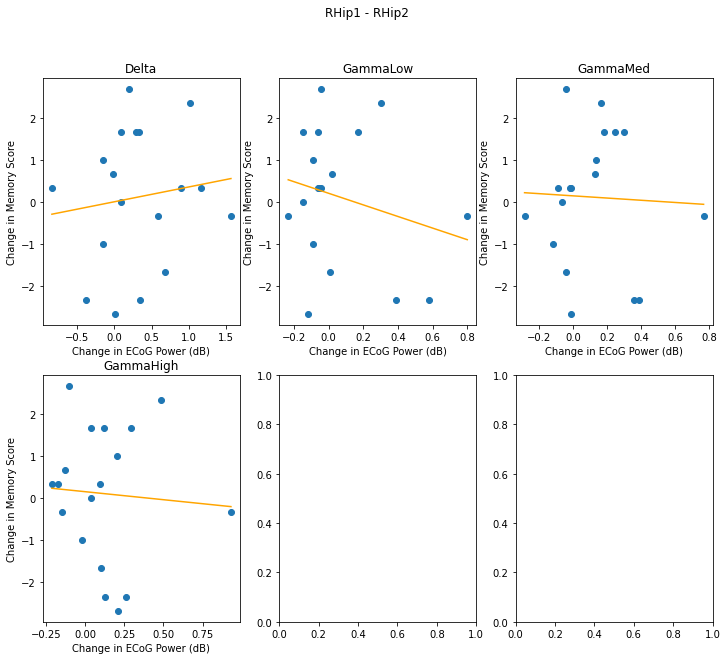

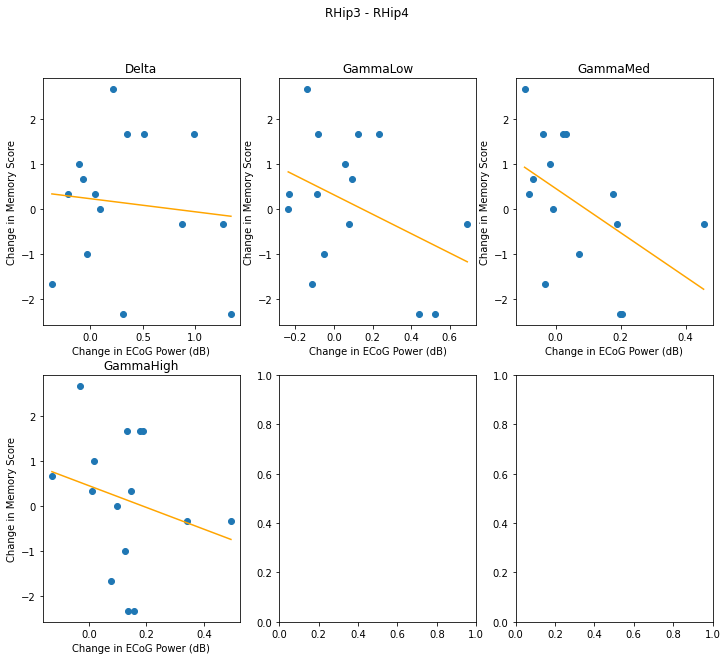

In [ ]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Memory_Score - Avg_Sham', 'Change in ECoG Power (dB)', 'Change in Memory Score', show_all_p=True, linreg_pval='perm', freqs=['Delta', 'GammaLow', 'GammaMed', 'GammaHigh'])

## Trial Memory Chg vs Power Pre (averaged)

Here, we have a correlation in the low and medium gamma bands of RHip1 - RHip2. The raw P-value is pretty strong and the regression line looks pretty good. However, it will only withstand FDR if we use stim memory only, rather than stim - sham, and we also have to narrow down our zone of interest to just the gamma frequencies, which may or may not be justifiable.

On the other hand, gamma split might not even be necessary for this, since the original analysis used Low + med (30-100) and found a P-value of 0.004829 in the same channel. Only problem there was that FDR erased the P-value when we accounted for our 20 comparisons.

Averaging across stims in the same patient, channel, and trial


Channel   Frequency         r         P
0   LHip1 - LHip2       Delta -0.098959  0.375539
1   LHip1 - LHip2       Theta -0.157889  0.335446
2   LHip1 - LHip2    GammaLow  0.122003  0.728777
3   LHip1 - LHip2    GammaMed  0.301340  0.203577
4   LHip1 - LHip2  GammaXHigh  0.130309  0.563317
5   LHip3 - LHip4       Delta -0.245088  0.512482
6   LHip3 - LHip4       Theta -0.223924  0.671705
7   LHip3 - LHip4    GammaLow -0.213374  0.616466
8   LHip3 - LHip4    GammaMed  0.154103  0.563317
9   LHip3 - LHip4  GammaXHigh  0.059618  0.969267
10  RHip1 - RHip2       Delta -0.044654  0.436969
11  RHip1 - RHip2       Theta  0.030226  0.484183
12  RHip1 - RHip2    GammaLow  0.693604  0.006516
13  RHip1 - RHip2    GammaMed  0.638572  0.008220
14  RHip1 - RHip2  GammaXHigh  0.303297  0.276484
15  RHip3 - RHip4       Delta -0.110620  0.476865
16  RHip3 - RHip4       Theta -0.028925  0.919057
17  RHip3 - RHip4    GammaLow  0.646610  0.019423
18  RHip3 - RHip4    GammaMed  0.688124  0.003208
19  RHip3 - RHip4  GammaXHigh  0.038429  0.611376

Linear regression:


Frequency      Delta  Theta  GammaLow  GammaMed  GammaXHigh
Channel                                                    
LHip1 - LHip2    NaN    NaN       NaN       NaN         NaN
LHip3 - LHip4    NaN    NaN       NaN       NaN         NaN
RHip1 - RHip2    NaN    NaN       NaN       NaN         NaN
RHip3 - RHip4    NaN    NaN       NaN       NaN         NaN

Fisher Exact:


Frequency      Delta  Theta  GammaLow  GammaMed  GammaXHigh
Channel                                                    
LHip1 - LHip2    NaN    NaN       NaN       NaN         NaN
LHip3 - LHip4    NaN    NaN       NaN       NaN         NaN
RHip1 - RHip2    NaN    NaN       NaN       NaN         NaN
RHip3 - RHip4    NaN    NaN       NaN       NaN         NaN

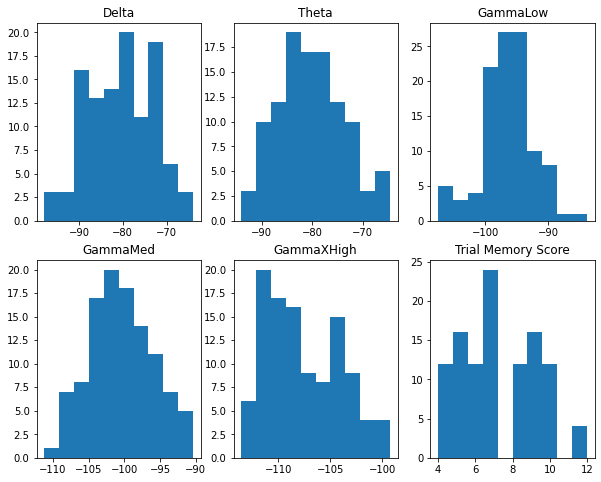

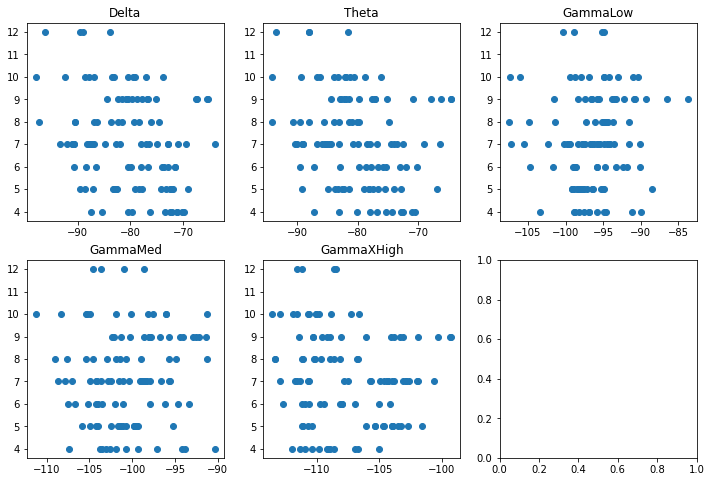

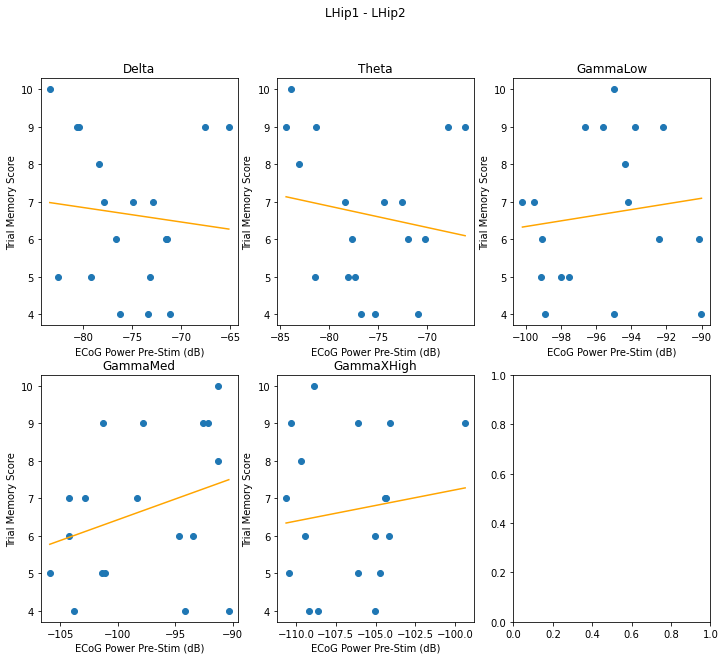

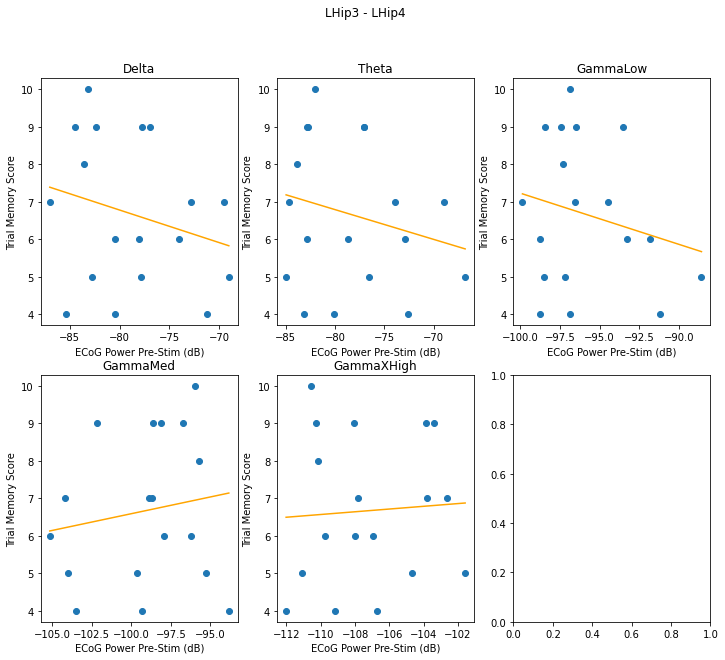

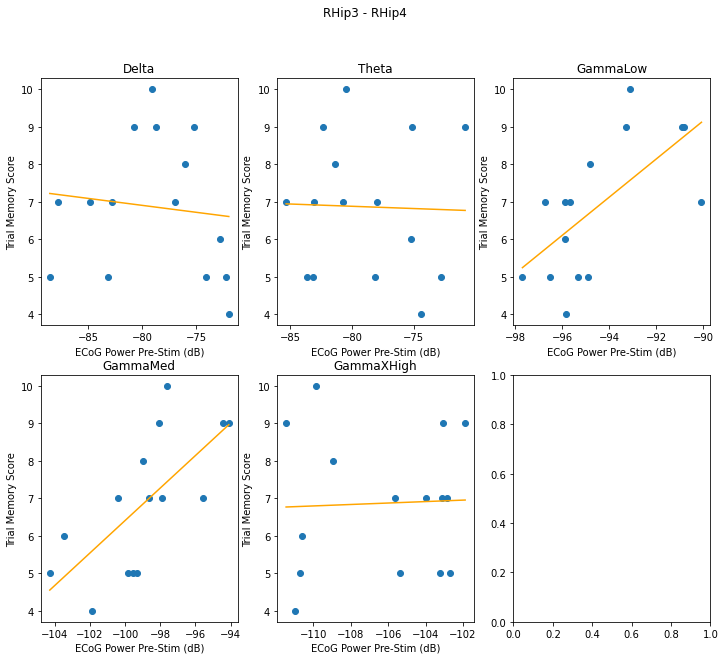

In [ ]:
do_stats(power_and_mem, '10 * log($FREQ_pre) / log(10)', 'Memory_Score', 'ECoG Power Pre-Stim (dB)', 'Trial Memory Score', linreg_pval='kendall', freqs=['Delta', 'Theta', 'GammaLow', 'GammaMed', 'GammaXHigh'])

Averaging across stims in the same patient, channel, and trial


Channel   Frequency         r         P
0   LHip1 - LHip2       Delta -0.037965  0.469592
1   LHip1 - LHip2       Theta -0.181277  0.304127
2   LHip1 - LHip2    GammaLow -0.078759  0.969640
3   LHip1 - LHip2    GammaMed  0.202375  0.341349
4   LHip1 - LHip2  GammaXHigh -0.131214  0.675463
5   LHip3 - LHip4       Delta -0.426729  0.182826
6   LHip3 - LHip4       Theta -0.446533  0.238054
7   LHip3 - LHip4    GammaLow -0.480335  0.137717
8   LHip3 - LHip4    GammaMed -0.049259  0.969640
9   LHip3 - LHip4  GammaXHigh -0.211448  0.269704
10  RHip1 - RHip2       Delta  0.027777  0.848785
11  RHip1 - RHip2       Theta  0.018041  0.674871
12  RHip1 - RHip2    GammaLow  0.501437  0.117938
13  RHip1 - RHip2    GammaMed  0.456930  0.061684
14  RHip1 - RHip2  GammaXHigh -0.001741  0.969581
15  RHip3 - RHip4       Delta  0.158366  0.802989
16  RHip3 - RHip4       Theta  0.085106  0.653384
17  RHip3 - RHip4    GammaLow  0.555978  0.040782
18  RHip3 - RHip4    GammaMed  0.344966  0.121916
19  RHip3 - RHip4  GammaXHigh -0.325619  0.343116

Linear regression:


Frequency      Delta  Theta  GammaLow  GammaMed  GammaXHigh
Channel                                                    
LHip1 - LHip2    NaN    NaN       NaN       NaN         NaN
LHip3 - LHip4    NaN    NaN       NaN       NaN         NaN
RHip1 - RHip2    NaN    NaN       NaN       NaN         NaN
RHip3 - RHip4    NaN    NaN       NaN       NaN         NaN

Fisher Exact:


Frequency      Delta  Theta  GammaLow  GammaMed  GammaXHigh
Channel                                                    
LHip1 - LHip2    NaN    NaN       NaN       NaN         NaN
LHip3 - LHip4    NaN    NaN       NaN       NaN         NaN
RHip1 - RHip2    NaN    NaN       NaN       NaN         NaN
RHip3 - RHip4    NaN    NaN       NaN       NaN         NaN

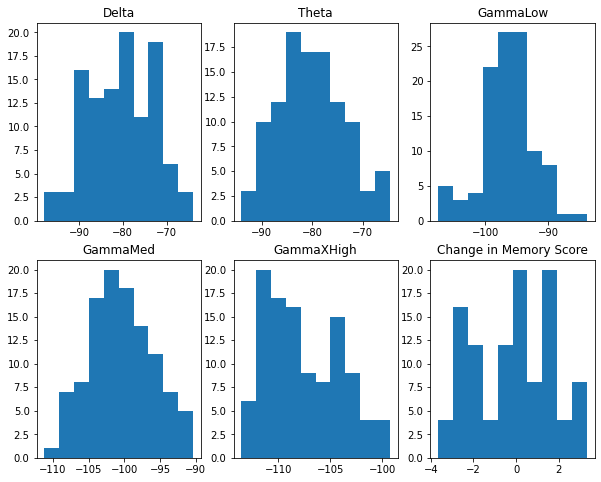

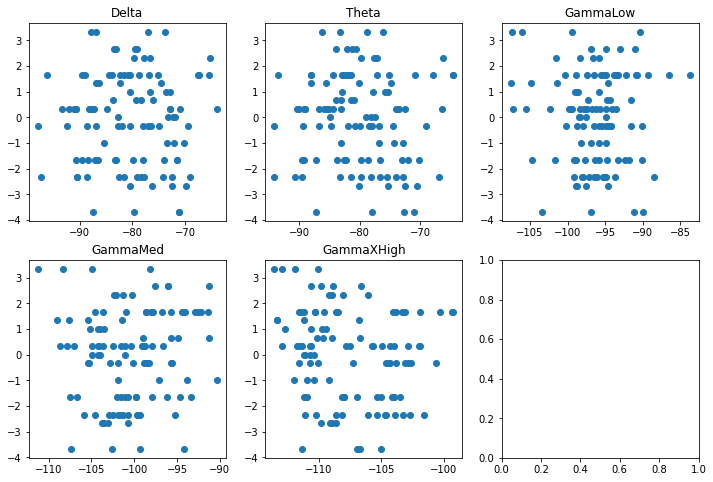

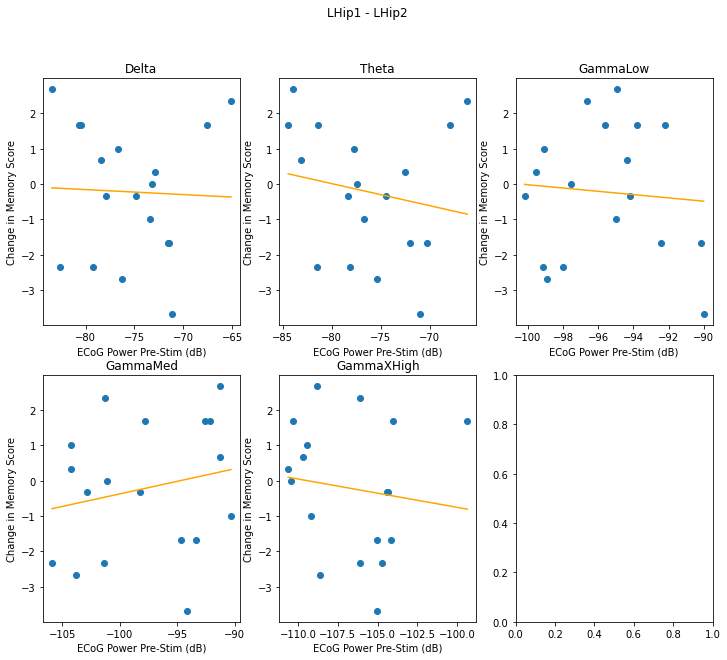

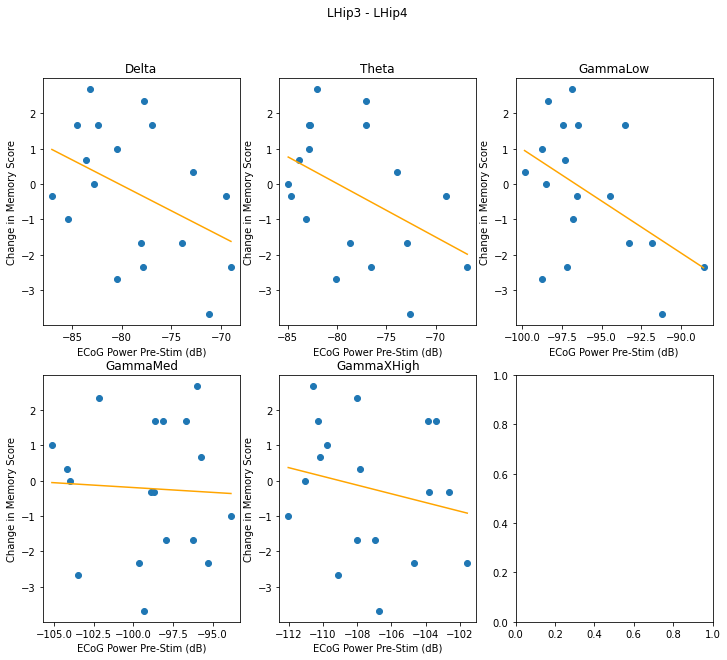

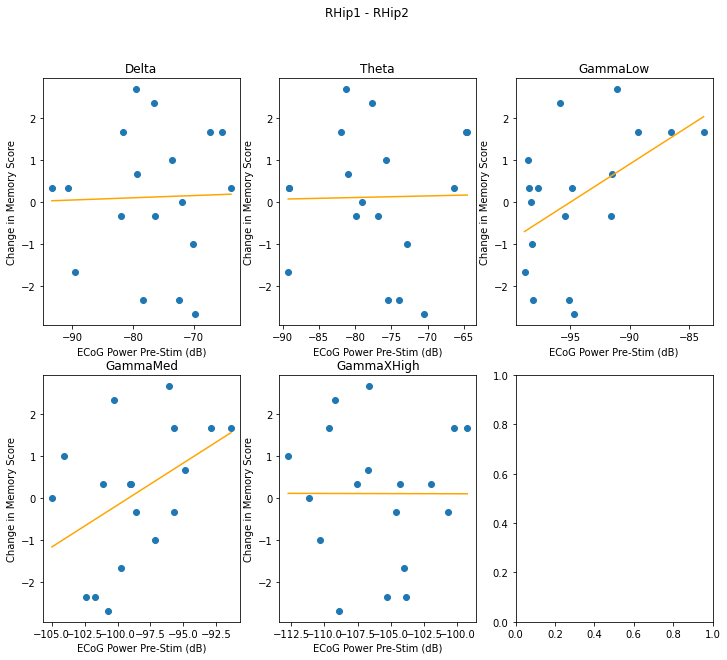

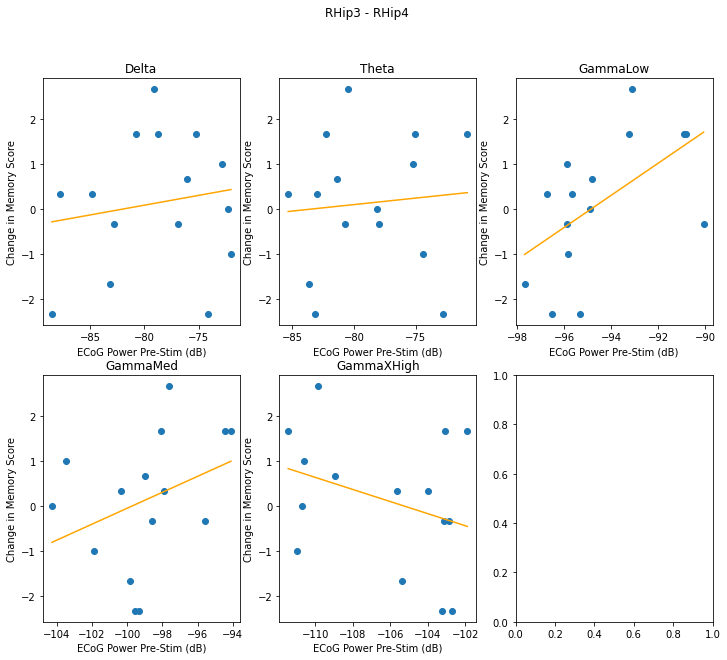

In [ ]:
do_stats(power_and_mem, '10 * log($FREQ_pre) / log(10)', 'Memory_Score - Avg_Sham', 'ECoG Power Pre-Stim (dB)', 'Change in Memory Score', linreg_pval='kendall', freqs=['Delta', 'Theta', 'GammaLow', 'GammaMed', 'GammaXHigh'])

## Delay Memory Chg vs Power Change (averaged)

Averaging power across all stims in the same patient and channel
Fisher Exact P-value = 0.2500000000000001 for Delta band in LHip1 - LHip2


Power         
                Decrease Increase
Memory Decrease        0        3
       Increase        1        0

Fisher Exact P-value = 0.2500000000000001 for GammaXHigh band in LHip1 - LHip2


Power         
                Decrease Increase
Memory Decrease        0        3
       Increase        1        0

Fisher Exact P-value = 0.3333333333333334 for Beta band in RHip1 - RHip2


Power         
                Decrease Increase
Memory Decrease        2        0
       Increase        0        1

Fisher Exact P-value = 0.3333333333333334 for GammaLow band in RHip1 - RHip2


Power         
                Decrease Increase
Memory Decrease        2        0
       Increase        0        1

Fisher Exact P-value = 0.3333333333333334 for GammaHigh band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        2        0
       Increase        0        1

Channel   Frequency         r         P
0   LHip1 - LHip2       Delta -0.638823  0.166667
1   LHip1 - LHip2        Beta  0.406306  0.416667
2   LHip1 - LHip2    GammaLow -0.059014  0.933333
3   LHip1 - LHip2    GammaMed -0.169456  0.766667
4   LHip1 - LHip2   GammaHigh -0.061303  0.916667
5   LHip1 - LHip2  GammaXHigh -0.499590  0.300000
6   LHip3 - LHip4       Delta -0.025920  0.983333
7   LHip3 - LHip4        Beta  0.170239  0.750000
8   LHip3 - LHip4    GammaLow  0.332899  0.500000
9   LHip3 - LHip4    GammaMed  0.326472  0.500000
10  LHip3 - LHip4   GammaHigh  0.550989  0.266667
11  LHip3 - LHip4  GammaXHigh -0.174960  0.716667
12  RHip1 - RHip2       Delta  0.273901  0.633333
13  RHip1 - RHip2        Beta  0.709817  0.100000
14  RHip1 - RHip2    GammaLow  0.949533  0.000000
15  RHip1 - RHip2    GammaMed  0.440735  0.400000
16  RHip1 - RHip2   GammaHigh  0.154648  0.783333
17  RHip1 - RHip2  GammaXHigh  0.187441  0.683333
18  RHip3 - RHip4       Delta  0.600321  0.266667
19  RHip3 - RHip4        Beta  0.937074  0.000000
20  RHip3 - RHip4    GammaLow  0.605043  0.266667
21  RHip3 - RHip4    GammaMed  0.545358  0.333333
22  RHip3 - RHip4   GammaHigh  0.724138  0.200000
23  RHip3 - RHip4  GammaXHigh  0.493494  0.366667

Linear regression:


Frequency         Delta      Beta  GammaLow  GammaMed  GammaHigh  GammaXHigh
Channel                                                                     
LHip1 - LHip2  0.769231  0.769231  0.973913  0.895238   0.973913    0.769231
LHip3 - LHip4  0.983333  0.895238  0.800000  0.800000   0.769231    0.895238
RHip1 - RHip2  0.895238  0.769231  0.000000  0.769231   0.895238    0.895238
RHip3 - RHip4  0.769231  0.000000  0.769231  0.769231   0.769231    0.769231

Fisher Exact:


Frequency      Delta  Beta  GammaLow  GammaMed  GammaHigh  GammaXHigh
Channel                                                              
LHip1 - LHip2    1.0   1.0       1.0       1.0        1.0         1.0
LHip3 - LHip4    1.0   1.0       1.0       1.0        1.0         1.0
RHip1 - RHip2    1.0   1.0       1.0       1.0        1.0         1.0
RHip3 - RHip4    1.0   1.0       1.0       1.0        1.0         1.0

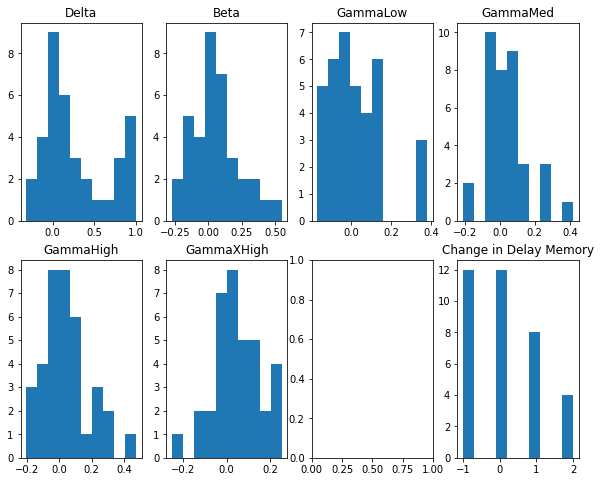

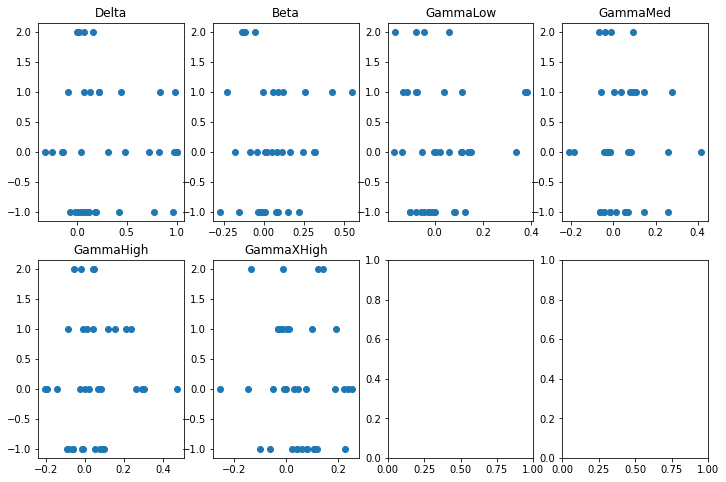

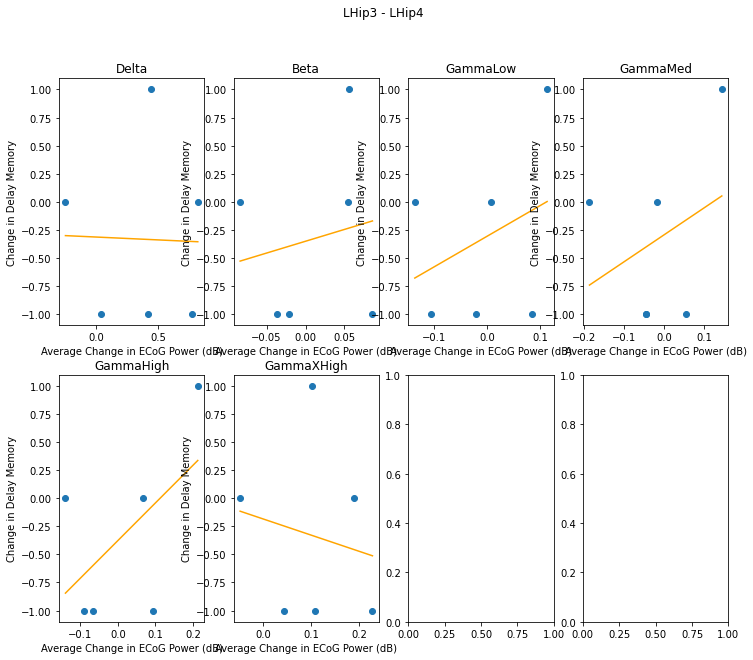

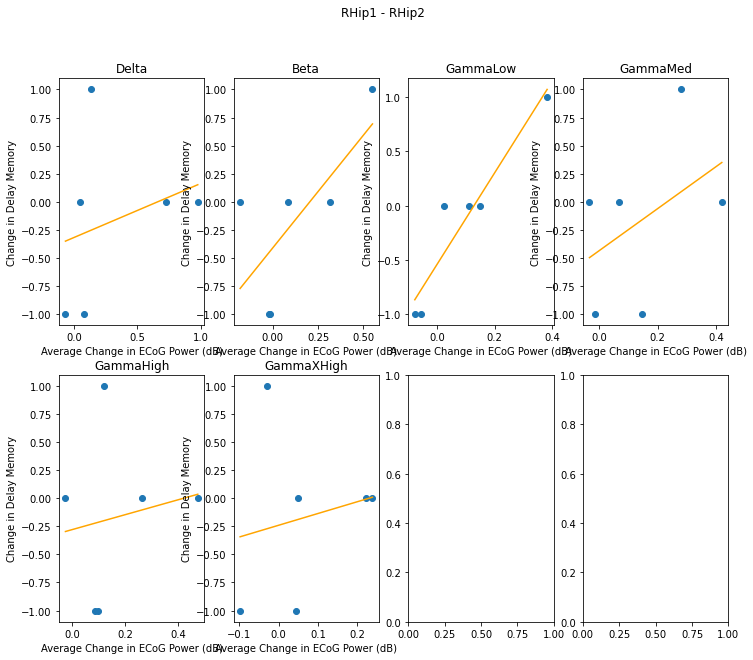

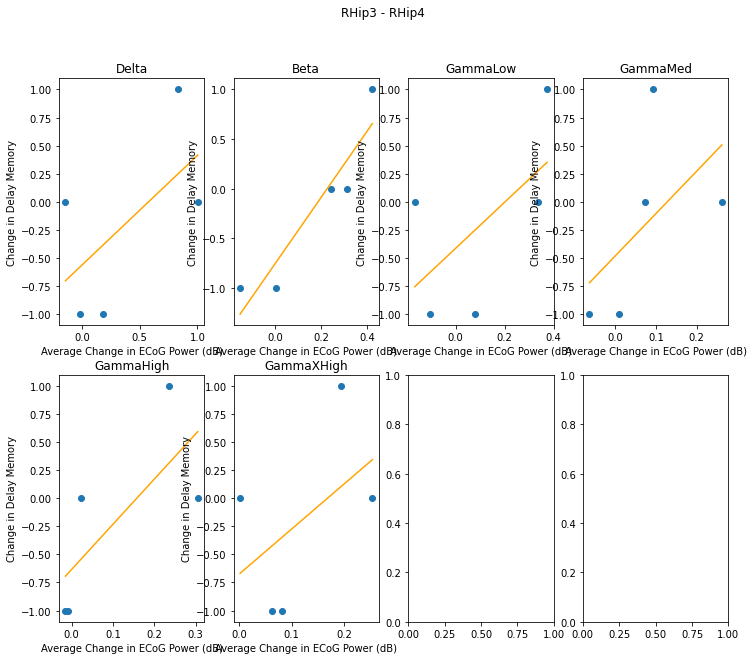

In [ ]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Delay_Mem_Stim - Delay_Mem_Sham', 'Average Change in ECoG Power (dB)', 'Change in Delay Memory', linreg_pval='perm', show_all_p=True, freqs=freqs)

# Sanity Checks

In [ ]:
power_and_mem[power_and_mem['ID'] == 109]['Channel'].unique()

array(['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip1 - RHip3'],
      dtype=object)

In [ ]:
power_and_mem[power_and_mem['ID'] == 106]['Channel'].unique()

array(['LPS1 - LPS2', 'LPS3 - LPS4', 'LPIH4 - LPIH1', 'LPIH4 - LPIH3'],
      dtype=object)

In [ ]:
(memory_delayed['Delay_Mem_Stim'] - memory_delayed['Delay_Mem_Sham']).mean()

2.4761904761904763

In [ ]:
mem_delay_any_stim = memory_delayed[memory_delayed['ID'].isin(power_log_chg['ID'].unique())]
(mem_delay_any_stim['Delay_Mem_Stim'] - mem_delay_any_stim['Delay_Mem_Sham']).mean()

0.9

# TODO
- John: average power for each trial on the x, plot trial memory on Y
- Haneef: 3-word groups, each stim would have own mem score
- sham recording power vs sham memory scores
    - does stimulation make that better or worse?
- mean change from sham to stim is zero for current 6-7 patients
    - change from short-term to delay instead of change from sham to stim
    - consider patient-level + 3-word group level for both


- currently looking at effect of stimulation
- need to confirm increase in delta not due to post-stim artifact
- zoom into box plot to compare medians
- look at power shifts instead of just amplitude-time
- permutation test for specific channels
- FDR corrections
- correlations between the power and memory
- FUTURE: look at amplitude changes across stim 1 vs 2 vs 3 vs 4
- FUTURE: phase-amplitude coupling
- FUTURE: coherence analysis
- FUTURE: spectrograms
- FUTURE: associate with memory changes

In [ ]:
pts_w_any_stim

[100, 103, 105, 106, 109, 110, 111, 112, 113, 115]

In [ ]:
pt_w_stim_not_111 = pts_w_any_stim[:6] + pts_w_any_stim[7:]
check_trials = memory_trials.loc[pt_w_stim_not_111,:]

In [ ]:
scipy.stats.ttest_rel(check_trials['Memory_Score'], check_trials['Avg_Sham'])

Ttest_relResult(statistic=-0.1064608583282014, pvalue=0.9160338975709146)

In [ ]:
check_stim = memory_delayed[memory_delayed['ID'].isin(pts_w_any_stim)]
# check_stim = check_stim[check_stim['ID'] != 111]
check_stim

ID  Delay_Mem_Stim  Delay_Mem_Sham
0   100             4.0               5
3   103            10.0               8
5   105             3.0               3
6   106            12.0              11
9   109             6.0               6
10  110             5.0               4
11  111             8.0               0
12  112             9.0              10
13  113             8.0               8
14  115             4.0               5

In [ ]:
scipy.stats.ttest_rel(check_stim['Delay_Mem_Stim'], check_stim['Delay_Mem_Sham'])

Ttest_relResult(statistic=1.0598427071714605, pvalue=0.31682960824765083)

In [ ]:
memory_delayed

ID  Delay_Mem_Stim  Delay_Mem_Sham
0   100             4.0               5
1   101             4.0               4
2   102             7.0               8
3   103            10.0               8
4   104             3.0               0
5   105             3.0               3
6   106            12.0              11
7   107            10.0               0
8   108             6.0               5
9   109             6.0               6
10  110             5.0               4
11  111             8.0               0
12  112             9.0              10
13  113             8.0               8
14  115             4.0               5
15  200             4.0               1
16  201             NaN               7
17  202             5.0               2
18  205             NaN               0
19  206             6.0               3
20  207             9.0               0
21  208             8.0               0
22  209             4.0               0